# Inversion Cheatsheet

This is a summary cheet sheet which combines the key principles into one easily accessible format for the purpose of revision and access during the class test.

### A quick note on using WSL

`Devito` may only be accessed in its most up to date form via WSL. To do so, follow this:

1. Open WSL and navigate to `environments`.
2. A Devito environment should already exist. If not, run `python3 -m venv devito`
3. Activate the environment with `source devito/bin/activate`
4. Now navigate to the relevant directory and run `jupyter notebook`

When you receive the exam, you will have to download it. Copy it to your cwd using

`cp /mnt/c/dnrlu/Users/dnrlu/Downloads/[name] .`

You will have cloned your up to date github repo to a suitable working folder by this point. Copy the exam there.

# Table of contents

[Lecture 1: Forward vs Inverse Problems, Linear Algebra](#lecture-1-forward-vs-inverse-problems-linear-algebra)

[Lecture 2: Optimisation, Rank, Range, Null Space](#lecture-2-optimisation,-rank,-range,-null,-space)

[Lecture 3: Full Waveform Inversion (FWI)](#lecture-3-full-waveform-inversion-fwi)

[Lecture 4: Least Squares, Minimum Norm, Non-square Cases](#lecture-4-least-squares-minimum-norm-non-square-cases)

[Lecture 5: Under, Over, and Mixed Determined Problems](#lecture-5-under-over-and-mixed-determined-problems)

[Lecture 6: Finite Differencing and Devito](#lecture-6-finite-differencing-and-devito)

[Lecture 7: 2D Wave Propagators](#2d-wave-propagators)

[Lecture 8: FWI Implementation](#fwi-implementation)

<hr/>

## Lecture 1: Forward vs Inverse Problems, Linear Algebra

In STEM, we must pose many problems as inversion or optimsations problems. In the most general sense, inversion asks for some function

$$y=f(x),$$

given $y$, what is $x$? This is contrary to the forward problem, which asks: given $x$, what is $y$? Thus, inversion problems can be formulated as

$$f(x) = y,$$

or more commonly as

$$A\mathbf{x}=\mathbf{b},$$

for a system of equations. Often, we choose to simplify our problem by approximating non-linear terms with linear functions. Then, it is important to remember that a linear function commutes with addition, i.e.,

$$f(\mathbf{x+y}) = f(\mathbf{x})+f(\mathbf{y}),$$
$$f(\alpha \mathbf{x})=\alpha f(\mathbf{x}), \ \alpha \in \mathbb{R}.$$

### Matrix properties

For some matrix $A$

$$\text{e.g.,} \ A = \begin{pmatrix} a & b \\ c&d \end{pmatrix}$$

the four basic matrix properties read that

$$(A+B)^T=A^T+B^T,$$

i.e., addition and transpose operations commute,

$$(\alpha A^T)=\alpha(A^T), \ \alpha \in \mathbb{R}$$

i.e., scalar multiplication and transpose operations commute,

$$(AB)^T = B^T A^T,$$

i.e., matrix multiplication and transpose operations commute, and finally

$$(A^T)^T = A.$$

Furthermore, we may say that

$$A=A^T \Leftrightarrow \ A \ \text{is symmetric},$$
$$A=-A^T \Leftrightarrow \ A \ \text{is skew symmetric},$$

in which case

$$A = \begin{pmatrix} 0 & b \\ -b&0 \end{pmatrix}.$$

This classification may be important later since the eigenvalues of a symmetric matrix are always real, and those of a skew symmetric matrix are always imaginary or zero.

**We can implement checks of these properties as below**



In [2]:
import numpy as np

In [3]:
"Checking transpose properties"

# Define arbitrary dimensions
m = 3
n = 3

# Generate our random matrix
A = np.random.random((m, n))
B = np.random.random((m, n))

# Addition commutation (ABt = AtBt)
ABt = (A+B).T
AtBt = A.T + B.T
print(f'Addition commutes: {np.allclose(ABt, AtBt)}')

# Scalar multiplication ((aA)t = a(At))
alpha = 5

aAt = (alpha * A).T
a_At = alpha * (A.T)
print(f'Scalar multiplication commutes: {np.allclose(aAt, a_At)}')

# Matrix multiplication ((AB)t = AtBt)
ABt = (A@B).T
AtBt = B.T @ A.T
print(f'Matrix multiplication commutes: {np.allclose(ABt, AtBt)}')

# Double transpose
Att = (A.T).T
print(f'Double transpose: {np.allclose(Att, A)}')

Addition commutes: True
Scalar multiplication commutes: True
Matrix multiplication commutes: True
Double transpose: True


### Matirx-vector multiplication

We can write a square matrix $A \in \mathbb{R}^{m\times n}$ as 

$$A=\begin{pmatrix} a_{11} & a_{12} & \dots & a_{1n} \\
a_{21} & a_{22} & \ddots & \vdots \\
a_{m1} & a_{m2} & \dots & a_{mn} \\
\end{pmatrix},$$

and a vector $\mathbf{x} \in \mathbb{R}^n$ as

$$\mathbf{x}=\begin{pmatrix} x_1 & x_2 & \dots & x_n \end{pmatrix}^T.$$

Then, the elements $b_i$ of the matrix vector multiple $A\mathbf{x} := \mathbf{b}$ can be written as

$$\mathbf{b_i} = \sum^{n}_{j=1} a_{ij}x_j, \ i=1,\ 2, \dots,\ m.$$

If we consider the vector elements as weights in the summation, then we can see from the summation that we can write $\mathbf{b}$ as

$$\mathbf{b} = \begin{pmatrix}A_{:1}x_1 & A_{:2}x_1 & \dots & A_{:m}x_n \end{pmatrix}^T,$$

where each element of the vector is equal to the sum of the column of $A$ multiplied or weighted by the corresponding component of $\mathbf{x}$. 

Why is does this mean the linear dependence or independence of the columns of $A$ is important?

Well, we can see that an exact solution to the problem only exists if $A$ has full rank, i.e., its columns are fully linearly independent. If the columns of $A$ are linearly independent, they form a basis for $\mathbb{R}^n$, meaning every $b\in \mathbb{R}^n$ can be expressed uniquely as a combination of the columns. If the columns are linearly independent, they do not span the whole space and thus some vectors $\mathbf{b}$ might not be reachable by any combination of the columns, meaning a solution doesn't exist. Alternatively, if they are reachable then there are infinitely many ways to express $\mathbf{b}$ and no unique solution exists. Thus, the linear independence of the columns of $A$ indicates the solvability of the system.

We can write up this way of thinking as below:

In [4]:
# Our function to execute matrix-vector mutliplication, as defined in the lecture

def mat_vec_product(A, x):
    m, n = np.shape(A)
    assert x.ndim == 1 # restrict to the case where x is 1D
    assert n == len(x) # as 1D we can check the length of x is consistent with A
    b = np.zeros(m) # and then initialise to zero the appropriate length array for b
    for i in range(m):
        for j in range(n):
            b[i] += A[i, j] * x[j]
    return b

In [5]:
# Defining our dimensions
m = 4
n = 4

# Let's define A and x
A = np.random.random((m, n))
x = np.random.random((n,))

# Executing the product using the function defined in the lecture
b = mat_vec_product(A, x)

# Computing the product directly
Ax = A@x

# Checking similarity between two methods
np.allclose(b, Ax)

True

## Example of a system with an exact solution, no solution, and infinitely many

In the case that $A$ has full rank, e.g.,

$$A=\begin{pmatrix}1&2\\3&4\\ \end{pmatrix},$$

an exact solution exists. In this case, the equations read

$$x_1 + 2x_2=b_1,$$
$$3x_1+4x_2=b_2,$$

and if our right hand vector is

$$\mathbf{b}=\begin{pmatrix}3 \\ 7 \end{pmatrix},$$

then there exists a single solution vector $\mathbf{x},$ that being

$$\mathbf{x}=\begin{pmatrix}1 \\ 1 \end{pmatrix}.$$

Alternatively, if our matrix is not full rank, for instance

$$A=\begin{pmatrix}1&2\\2&4\\ \end{pmatrix},$$

Then there exist no solutions or infinitely many. Our equations now read

$$x_1 + 2x_2=b_1,$$
$$2x_1+4x_2=b_2,$$

In this case $A_{:1}x = 2A_{:2}x$ and the problem is thus under determined. Then, if we have

$$\mathbf{b}=\begin{pmatrix}3 \\ 7 \end{pmatrix},$$

then we can see that no non-zero solution vectors exist since we require that  

$$x_1+2x_2 = 3,$$

and 

$$x_1+2x_2 = 7/2,$$

which is clearly impossible and no solutions exist. If instead we had

$$\mathbf{b}=\begin{pmatrix}3 \\ 6 \end{pmatrix},$$

then the two equations read

$$x_1 + 2x_2 = 3,$$

for which there are clearly an infinite number of combinations of $x_1$ and $x_2$ that satisfy the equations.

### Newton's method

We can often pose an inversion problem as a root finding problem by solving iteratively for $x_{i+1}$. If we have some function $f$, then we can find a root by setting $f(x)=0$ and solving for $x$. Newton's iterative solution method reads  

$$x_{i+1}=x_i - \frac{f(x_i)}{f'(x_i)}.$$

### Curve fitting

With a system of equations, often it is the case that there is no absolute solution vector which satisfies all constraints posed by the equations in the model. In this case, our inversion problem becomes an optimisation problem. The least squares solution minimises the square difference between a function evaluated at a guess location $x_i$ and the given data points. The error $E$ can be defined as

$$||A\mathbf{x}-\mathbf{y}||^2_2.$$

It will be shown later that the least squares solution to the system $A\mathbf{x}=\mathbf{b}$ is found by solving

$$A^TA\mathbf{x}=V^T\mathbf{y},$$

which holds for under determined problems. We can approximate a polynomial for a given set of data in the following manner.

In [6]:
import matplotlib.pyplot as plt


poly_coeffs = 
 [-0.00552147  0.09889271 -0.43193108  0.75909819]


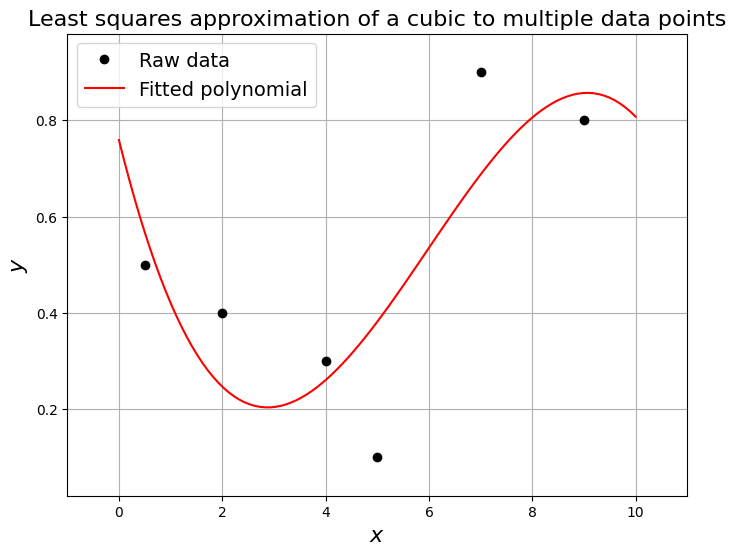

In [7]:
# Our data from Lecture 1:
x = np.array([0.5, 2.0, 4.0, 5.0, 7.0, 9.0])
y = np.array([0.5, 0.4, 0.3, 0.1, 0.9, 0.8])

# Consider a polynomial of degree 3 - so not high enough to go through all the data
N = 3

# Compare against the coefficient that numpy's polyfit gives us
poly_coeffs = np.polyfit(x, y, N)
print('\npoly_coeffs = \n', poly_coeffs)

xx = np.linspace(0, 10, 100) # To generate smooth curve

# Evaluate the polynomial at the given x values
y_poly = np.polyval(poly_coeffs, xx)

# set up figure
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.margins(0.1)

# Overlay raw data
ax1.plot(x, y, 'ko', label='Raw data')
ax1.plot(xx, y_poly, 'r-', label='Fitted polynomial')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Least squares approximation of a cubic to multiple data points', fontsize=16)
ax1.grid(True)
ax1.legend(loc='best', fontsize=14);

---

## Lecture 2: Optimisation, Rank, Range, and Null Space

Optimisation seeks to find a value for $x$ such that

$$f(x),$$

has a minimum value. A simple way to approach this problem is to slve

$$f(x)=0,$$

for $x$. In this case, we have posed the optimisation problem as an inversion problem by asking "given $f'(\bullet)=0,$ what is $\bullet$?". This will give us the stationary points of the problem.

We can also pose inversion as an optimisation problem by defining a misfit term and perturbing our model such that the misfit is miniised. The least squares solution is an example of this.

#### Geometric thinking: a brief note on solvability

Understanding existence and uniqueness is simple in the case of a system of two linear equations. If a unique solution exists then those two lines intersect at one point. Then, there are two remaining cases:

- They never intersect (non-existence)
- They intersect at every point (non-uniqueness)

### (Reduced) row echelon form

Regardless of the solution approach, there are three important things to clarify when solving an inversion problem:

1. Does a solution exist?
2. Is the solution unique?
3. Is the solution stable?

To understand these queries we can transform our matrix to Row Echelon Form (REF). In this form,

- All pivot rows have a leading 1,
- All rows containing non-zero terms are above a row of all zeros.

Note that sometimes we may want to transform to Reduced Row Echelon Form (RREF), in which case **every column containing a leading 1 has zeros everywhere else in the column.** Putting the matrix in this form leads to an interesting case wheb $A\mathbf{x}=0,$ because the final equation in the system will read $0x_n =0,$ We will see more on this after we transform the matrix.

Let's go through an example of how to form the REF and RREF. Remember that each row of our matrix encodes the algebraic system and thus we can

- Multiply each row by a non-zero scalar
- Add mutliples of one row to another
- Swap rows

Let's begin.

$$ A =
\begin{pmatrix}
-2 & -4 & -20 \\
2 & 6 & 24 \\
2 & 10 & 32
\end{pmatrix},
$$

$(1) \leftarrow -0.5\times(1),$

$$
\begin{pmatrix}
1 & 2 & 10 \\
2 & 6 & 24 \\
2 & 10 & 32
\end{pmatrix},
$$

$(3) \leftarrow (3) - 2\times (1),$

$$
\begin{pmatrix}
1 & 2 & 10 \\
2 & 6 & 24 \\
0 & 6 & 12
\end{pmatrix},
$$

$(2) \leftarrow (2) - 2\times (1),$

$$
\begin{pmatrix}
1 & 2 & 10 \\
0 & 6 & 24 \\
0 & 6 & 12
\end{pmatrix},
$$

$(2) \leftarrow 0.5(2) - (1),$

$$
\begin{pmatrix}
1 & 2 & 10 \\
0 & 1 & 2 \\
0 & 6 & 12
\end{pmatrix},
$$

$(3) \leftarrow (3) - 6\times (2),$

$$
\begin{pmatrix}
1 & 2 & 10 \\
0 & 1 & 2 \\
0 & 0 & 0
\end{pmatrix},
$$

which now satsifies the conditions of a REF matrix. Let's perform a final operation to achieve RREF.

$(1) \leftarrow (1) - 2\times (2),$

$$
\begin{pmatrix}
1 & 0 & 6 \\
0 & 1 & 2 \\
0 & 0 & 0
\end{pmatrix}.
$$

### Rank, range, and null space

With a RREF matrix, we can characterise the solvability of a system $A\mathbf{x}=\mathbf{b}$ by setting $\mathbf{b}=0$ and ignroing the trivial case of $\mathbf{x}=0.$ By doing so, we can parameterise the *null space* of the system, which is the vector space which contains all vectors $\mathbf{x}$ that are solutions to the equation $A\mathbf{x}=0$.

Now, we want to first check the *rank* of the matrix, which is the number of linearly independent columns (i.e., the number of columns which may be combined as scalar multiples to form another). The columns of our matrix are

$$
\mathbf{c}_1 = \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}, \quad
\mathbf{c}_2 = \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}, \quad
\mathbf{c}_3 = \begin{pmatrix} 6 \\ 2 \\ 0 \end{pmatrix},
$$

and we want to check if there are scalars \( a \) and \( b \) such that:

$$
a \mathbf{c}_1 + b \mathbf{c}_2 = \mathbf{c}_3.
$$

This equation is satisfied by $a = 6, \ c=2.$ Thus we have that the third column can be formed by a linear combination of the scalar multiples of the 1st and 2nd, meaning the rank of the matrix is 2.

Now, let's parameterise the null space. The system

$$ A\mathbf{x} \equiv
\begin{pmatrix}
1 & 0 & 6 \\
0 & 1 & 2 \\
0 & 0 & 0
\end{pmatrix}\begin{pmatrix}
x_1 \\
x_2  \\
x_3 
\end{pmatrix} = 0,
$$

reads equivalently

$$x_1 + 6x_3 = 0,$$
$$x_2 +2x_3 = 0.$$

Now, if we set $x_3 = \alpha, \ \alpha \in \mathbb{R}, \alpha \neq 0 $ then our null space is clearly defined by the vector  

$$null(A)=\alpha \begin{pmatrix}6 \\  2 \\ 1\end{pmatrix},$$

which is equivalent to saying

$$null(A)= span\begin{pmatrix}6 \\  2 \\ 1\end{pmatrix},$$

meaning that the null space spans all scalar multiples of null(A).

#### Implications of the rank and null space

The dimension of the null space and the rank are related by teh rank-nullity thereom, which we will encounter later. For now, just know that **if a matrix is full rank, its null space is trivial and equal to zero.** Otherwise, recall that a full solution to a system of equations can be written as

$$\mathbf{x} =\mathbf{x}_p + \mathbf{x}_h, $$

or, in other words, as the sum of the particular and homogeneous solutions. In our case, the null space is the parameterised homogeneous solution space and all scalar multipels of the null space vector may be added to a particular solution of the equation $A\mathbf{x}=\mathbf{b}$ to give an equally viable solution. We will see in a later lecture that adding a multiple of the null spcae vector to a minimised solution provides a unique and non-trivial solution, but that perturbing the particular solution in this way increases misfit.

Note also that for the equation  $A\mathbf{x}=\mathbf{b}$ to have a solution, we require that $\mathbf{b}$ is in the column space, or span of $A$. If $\mathbf{b}$ is not in the column space of $A$, a solution does not exist. We can visualise the column space as follows:

Rank of A: 2
Rank of A: 1


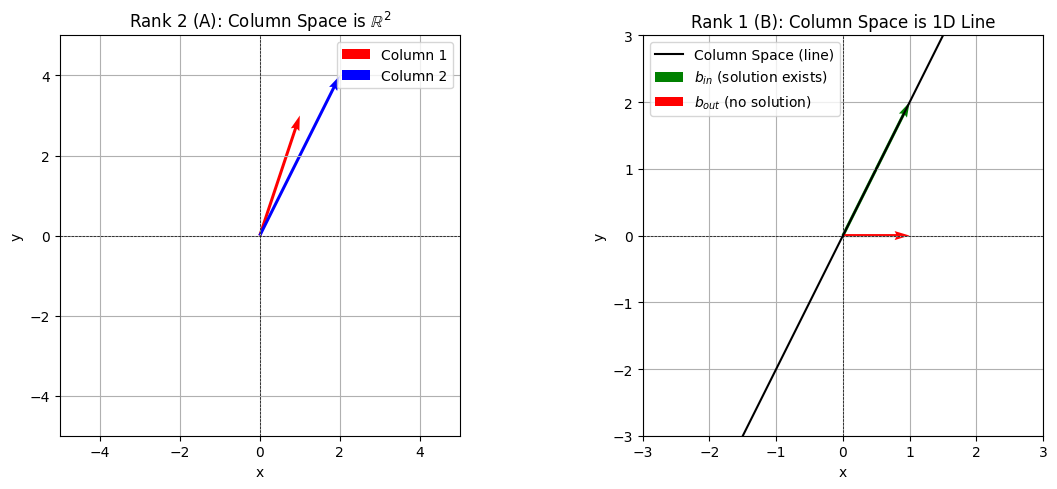

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define matrices
A = np.array([[1, 2], [3, 4]])  # Full-rank matrix (rank 2)
B = np.array([[1, 2], [2, 4]])

# Verify ranks
print(f"Rank of A: {np.linalg.matrix_rank(A)}")  # Should be 2
print(f"Rank of A: {np.linalg.matrix_rank(B)}")  # Should be 1

# Define b vectors for rank-1 case
b_in = np.array([1, 2])  # In column space of A (same as first column)
b_out = np.array([1, 0])  # Not in column space of A

# Set up plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot for rank-2 matrix (A)
ax1.quiver(0, 0, A[0, 0], A[1, 0], color='r', angles='xy', scale_units='xy', scale=1, label='Column 1')
ax1.quiver(0, 0, A[0, 1], A[1, 1], color='b', angles='xy', scale_units='xy', scale=1, label='Column 2')
ax1.set_xlim(-5, 5)
ax1.set_ylim(-5, 5)
ax1.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax1.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title(r'Rank 2 (A): Column Space is $\mathbb{R}^2$')
ax1.legend()
ax1.grid(True)
ax1.set_aspect('equal')

# Plot for rank-1 matrix (B)
# Column space is span of [1, 2], plot as a line
t = np.linspace(-5, 5, 100)
col_space_x = t * B[0, 0]
col_space_y = t * B[1, 0]
ax2.plot(col_space_x, col_space_y, 'k-', label='Column Space (line)')
ax2.quiver(0, 0, b_in[0], b_in[1], color='g', angles='xy', scale_units='xy', scale=1, label=r'$b_{in}$ (solution exists)')
ax2.quiver(0, 0, b_out[0], b_out[1], color='r', angles='xy', scale_units='xy', scale=1, label=r'$b_{out}$ (no solution)')
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)
ax2.axhline(0, color='k', linestyle='--', linewidth=0.5)
ax2.axvline(0, color='k', linestyle='--', linewidth=0.5)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Rank 1 (B): Column Space is 1D Line')
ax2.legend()
ax2.grid(True)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

#### Relation to inversion

If a square matrix $A \in \mathbb{R}^{n\times n}$ is invertible, then the rank of $A$ is equal to $n$ and the null spcae contains only the trivial case of the zero vector and there exists a unique solution vector $\mathbf{x}$ for $A\mathbf{x} = \mathbf{b}.$ If $A$ is not invertible, the null space of the matrix is non-trivial and contains infinitely may solutoions.

If $A$ is singular (non-invertible, i.e., $det(A) = 0$), then there are two possible cases

- Non-existence: $\mathbf{b}$ is not in the column space of $A$
- Non-uniquness: there are an infinite number of solutions in the null space

Understanding the rank and null space of a matrix helps to assess the feasability of solving an inverse problem.

#### Relation to tomography

**This is an important point to understand.**

Tomography problems are under determined by construction. When we solve the inverse problem, we look for a particular and a homogeneous solution and sum them to find a final solution vector of say, slowness such that $G\mathbf{x}$ is equivalent to the recorded travel times. We can write this as

$$\mathbf{x} = \mathbf{x}_p + \sum^{n}_{i=1} c_{i} \mathbf{x}_h. $$

Above, $\mathbf{x_p}$ is a particular solution which we will aim to arrive at using a damped least squares optimisation, for instance, and $x_h$ are our solution vectors that live in the null space that are valid $c_i \in \mathbb{R}$. This is the part that is important to consider.

We are basically trying to find a solution vector $\mathbf{x}$ that *does not change the travel times*. This is very useful for understanding the null space vector because we find them to be the solution to the homogeneous equation

$$G \mathbf{x}_h = 0,$$

and, in setting the problem in this way, we are asking the question: "What is the direction $\mathbf{x}_h$ in which a slowness perturbation by some constant will have no affect on the travel time we are using as a reference for our model?".

i.e., how can we parameterise the vector(s) that will tell us how to perturb our velocities in order to recreate the recorded travel times.

---

## Lecture 3: Full Waveform Inversion (FWI)

### Intro/ the Wave Equation

FWI attempts to resolve the full wavefield in the subsurface. We tend to have a forward and adjoint problem which must be solved 15 times at >3000 time steps and, as a result, FWI is very expensive. On a supercomputer, it takes weeks to solve.

Generally, we look to solve some form of the acoustic wave equation in forward and reverse at every node in a mesh for every time step. The most general form of the wave equation is

$$\frac{1}{c^2} u_{tt} - \nabla^2 = s,$$

where $s$ is some source perturbation, typically a Black-Ricker wavelet.

#### Derviation

For a simple derivation of the 1D acoustic wave equation we consider an isotropic and homogeneous elastic string where $u(x,\ t)$ describes the displacement at position $x$ and time $t$ over a small subinterval $[x_1,\ x_2]$. The total acceleration $a$ in the $u$ direction in this interval is then

$$a = \partial^2_t\int^{x_2}_{x_1} u(x,\ t) dx = \int^{x_2}_{x_1} u_{tt}(x,\ t) dx.$$

The total force $F(u)$ acting on this interval will be the net forces acting at the two points and, considering each point to have unit mass, Newton's law results in

$$a=F(u(x_2,\ t)) - F(u(x_1,\ t)) = \int^{x_2}_{x_1} F_x(u(x,\ t)) dx.$$

Now, assuming the force $F$ is proportional to the slope of the string with a proportionality factor $c^2$, which can be justified for small displacements, we find that

$$F(u)\approx c^2 u_{xx},$$

leading to

$$\int^{x_2}_{x_1} (u_{tt} - c^2 u_{xx}) dx = 0,$$

and since this holds for an arbitrary interval $[x_1,\ x_2]$ we find that

$$\frac{1}{c^2}u_{tt} = u_{xx},$$

which is the 1D wave equation.

#### Matrix form

The wave equation represents a linear relationship between a wavefield $u$ and the source $s$ that perturbs it. After discretisation, we can write the wave equation in matrix form as

$$A\mathbf{u}= \mathbf{s},$$

where $\mathbf{u}$ and $\mathbf{s}$ are column vectors that represent the source and wavefield at discrete points in space and time and $A$ is a matrix that represents the discrete numerical implementation of the operator

$$\frac{1}{c^2}\frac{\partial^2}{\partial t^2} - \nabla^2.$$

Note that while the wave equation represents a linear relationship between source and wavefield, the relation between a model $\mathbf{m}$ and the wavefield is non-linear. Thus we may also write

$$G\mathbf{m} = \mathbf{u},$$

and here $\mathbf{m}$ is a column vector that contains the model parameter. Typically, these may be values of $c$ at every point in the model, but they could be any set of parameters sufficient to describe the model. In this case, $G$ is a non-linear function which describes how to calculate the wavefield given a model.

In FWI, it is common to construct the problem such that $A$ is a matrix which represents a wave travelling in forward in time such that its inverse is a wave travelling backwards in time.

### Newton's method & optimisation

Newton's method provides an iterative scheme for root finding. In root finding problems, we seek some $x$ s.t. $f(x)=0$. The derivation begins with a Taylor series of the form

$$f(x) = f(x_0 + \partial x) = f(x_0) + dx \frac{df}{dx}|_{x_0} + \frac{1}{2}dx^2 \frac{d^2f}{dx^2}|_{x_0} + \dots.$$

Then, truncating terms higher than 2nd order, we can write 

$$f(x + \partial x) \approx f(x) + \partial x f'(x).$$

We seek to find the $x$ s.t. $f(x+\partial x) = 0$ and thus we can write $\partial x$ to be

$$\partial x = -\frac{f(x)}{f'(x)},$$

or, as an iterative update scheme, Newton's method:

$$x_{n+1} = x_n -\frac{f(x)}{f'(x)},$$

We can often pose an inversion problem as a root finding problem by solving iteratively for $x_{i+1}$. If we have some function $f$, then we can find a root by setting $f(x)=0$ and solving for $x$. Then, in a similar way, if we have $g(x)=f'(x)$ then the $x$ for which $g(x)=0$ are minimum solutions to the problem. By posing the problem in this manner it becomes a minimsiation problem (where we seek to find some $x$ that minimises $f(x)$) and we can apply Newton's method as

$$x_{i+1}=x_i - \frac{g(x_i)}{g'(x_i)}$$

A simple implementation of this is seen below.

In [9]:
# Newton's method as root finding algorithm

def f(x): # f(x) = 0
    return np.exp(x) + x

def dfdx(x):
    return np.exp(x) + 1

def root(xn, tol):
    n = 0
    while f(xn) > tol:
        x_np1 = xn - f(xn)/dfdx(xn)
        xn = x_np1
        n += 1

    return xn, n

tol = 1e-6

xn, nits = root(3, tol)

print(f'x_n: {xn}, n_iterations: {nits}')


x_n: -0.5671432803121138, n_iterations: 6


In [10]:
# Newton's method as an optimisation scheme

# Let's define our 1st and 2nd derivative

def df(x): # f' = g
    return np.exp(x) - 1

def df2(x): # f'' = g'
    return np.exp(x)

def minima(xn, tol):
    n = 0
    while df(xn) > tol:
        x_np1 = xn - df(xn)/df2(xn)
        xn = x_np1
        n += 1

    return xn, n

tol = 1e-6 # Arbitrary tolerance
xn, nits = minima(0.5, tol)
print(f'x_n: {xn}, n_its: {nits}')

x_n: 1.1216488698567219e-10, n_its: 4


#### Newton's method in vector form/ the Hessian

When we generalise Newton's method to vectors, we use that

$$\frac{d}{d\mathbf{x}}\left(\mathbf{x}^T A \mathbf{x} \right) = \left(\mathbf{x}^T A \right)^T + A\mathbf{x},$$

to evaluate

$$f(\mathbf{m}) = f(\mathbf{m}_0 + \partial \mathbf{m}).$$

I will not detail the derivation here, but trust that following the Taylor series derivation and applying the above well known result yields an expression for a model update $\partial \mathbf{m}:$

$$\partial \mathbf{m} \approx - \left( \frac{\partial^2 f}{\partial \mathbf{m}^2} \right) \frac{\partial f}{\partial \mathbf{m}} \equiv -H^{-1} \nabla_{m}f.$$

Here, $\nabla_m f$ is the gradient of the objective function $f$ with respect to the model parameters and $H$ is the Hessian matrix of second derivatives like

$$
H =
\begin{bmatrix}
\frac{\partial^2 f}{\partial m_1^2} & \frac{\partial^2 f}{\partial m_1 \partial m_2} & \cdots & \frac{\partial^2 f}{\partial m_1 \partial m_n} \\
\frac{\partial^2 f}{\partial m_2 \partial m_1} & \frac{\partial^2 f}{\partial m_2^2} & \cdots & \frac{\partial^2 f}{\partial m_2 \partial m_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial m_n \partial m_1} & \frac{\partial^2 f}{\partial m_n \partial m_2} & \cdots & \frac{\partial^2 f}{\partial m_n^2}
\end{bmatrix}.
$$

Let's consider a practical example for this. If $f$ is the two variable function

$$f(x, \ y) = (x-2)^4 + (y-3)^4 ,$$

we can use the above result to find the minimum.

For some function $f(x, y),$ the derivative is
$$\nabla f(x, y) = \begin{bmatrix} \frac{df}{dx} \\ \frac{df}{dy} \end{bmatrix},$$

and the Hessian in $(x,\ y)$ is

$$Hf(x, y) = \begin{bmatrix}\frac{d^2f}{dx^2} & \frac{d^2f}{dxdy} \\ \frac{d^2f}{dxdy} & \frac{d^2f}{dy^2} \end{bmatrix}.$$

$d\mathbf{x}$ is then

$$d\mathbf{x}=H^{-1}\nabla f,$$

which we can frame as an iterative problem by writing

$$d\mathbf{x}_{n+1} = d\mathbf{x_n} - H^{-1}\nabla f,$$

and we may begin with an intial guess for $\mathbf{x}_n, $ $\mathbf{x}_0,$ where

$$\mathbf{x}_0 = \begin{pmatrix}x_0 \\ y_0 \end{pmatrix}.$$

Right, let's implement this.

In [11]:
# Let's define our function f (the objective function)
import numpy as np
def f(x, y): # f(x, y) = 0
    return (x - 2)**4 + (y - 3)**4

def dx2(x):
    return 12*(x - 2)**2

def dy2(y):
    return 12*(y - 3)**2

def Hess(x, y): # Directly compute Hessian matrix
    dxdy = 0
    return np.array([[dx2(x), dxdy], [dxdy, dy2(y)]])

def gradf(x, y): # Compute nabla f
    return np.array([4*(x - 2)**3, 4*(y - 3)**3])

def minima(x, y, tol=1e-15, max_iters=100): # compute the minima
    xn = np.array([x, y]) # construct x_n vector

    for _ in range(max_iters):

        H = Hess(*xn)
        nabla_f = gradf(*xn)

        if np.linalg.norm(nabla_f) < tol: # kill loop if tolerance reached
            return xn

        xn -= np.linalg.solve(H, nabla_f) # .solve yields H^-1 @ nabla_f

    return xn

x, y = 5., 7.
result = minima(x, y)
print(f'Minimum found: {np.allclose(np.array([2, 3]), result)}')
print(result)

Minimum found: True
[2.00000309 3.00000412]


#### Steepest descent

Calculating the Hessian is not usually computationally feasible. Often we replace the Hessian with a simple scalar $\alpha$ such that we now have

$$\partial \mathbf{m} = -\alpha \frac{\partial f}{\partial \mathbf{m}} = -\alpha \nabla_{\mathbf{m}} f.$$

This is the method of steepest descenet, and consists of the following steps:

1. Start with a model $\mathbf{m}_0$,
2. Evaluate the gradient of the objective function $\nabla_m f$ for the current model,
3. find the step length $\alpha$,
4. subtract $\alpha$ times the gradient from the current model,
5. iterate from step 2 until the objectve function is sufficiently small.

Essentially, what we are doing is looking to step an optimal distance $\alpha$ in the direction which leads us towards a minimum in $f$. The iterative scheme to implement this is

$$\mathbf{m}_{n+1} = \mathbf{m}_n - \alpha \nabla_{\mathbf{m}}f.$$

#### Gradient

But, how do we actually find the gradient? Well, skipping over the details, just know we must compute

$$\nabla_mf = -\mathbf{u}^T \left(\frac{\partial A}{\partial \mathbf{m}} \right)^T (A^{-1})^T \mathbf{R}^T \delta \mathbf{d}. $$

Above, $\mathbf{u}$ is the forward wavefield, $A$ is the numerical operator in

$$A\mathbf{u} = \mathbf{s},$$

$\mathbf{R}$ is a diagonal restriction matrix (non-zero values only where data exists), and $\mathbf{d}$ is our data. Typically, we must evaluate this at every grid point in the mode.

To simplify the computations in the time domain, the numerical operator $A$ is designed such that it is symmetrical (self-adjoint, i.e. its transverse is the adjoint s.t. energy conservation holds in both directions in time). Somehow this means that our gradient calculation can now be written as

$$\nabla_{\mathbf{m}}f=-\mathbf{u}^T \left(\frac{\partial A}{\partial \mathbf{m}} \right)^T \delta \mathbf{u}.$$

It is important to note here that $\delta \mathbf{u}$ is the wavefield generated by back-propagating the data residuals. The middle bit is calculated analytically.

---

## Lecture 4: Least Squares, Minimum Norm, Non-square Cases

Recall from our exploration of rank and null space that a system is said to be linearly independent if given a set of vectors or columns of a matrix, one of them can be writen as a linear sum of scalar multiples of the others.

### Basis

A basis for a vector space is a set of linearly-independent vectors such that every vector can be written as a linear combination of the set. Consider
$\mathbb{R}^3$. The basis of the 3D real number space is

$$\mathbf{i} = \begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}, \ \mathbf{j} = \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}, \ \mathbf{k} = \begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}$$

these have the property of being orthogonal, i.e.,

$$\mathbf{i} \bullet \mathbf{i} = 1,$$
$$\mathbf{i} \bullet \mathbf{j} = 0.$$

Note that orthogonality is not required of basis vectors. In the above case, we call the basis *orthonormal*, because each vector is of unit size and orthogonal to the others.

The linear combination idea implies that every set of basis vectors can be combined linearly to reach any point in the vector space. If we recall that we can think of $A\mathbf{x}$ as being the weighted sum of the columns of $A$, i.e.,

$$A\mathbf{x} = \sum^{m}_{i=1} x_i a_{:i}, $$

then it is clear that the span or column space of $A$ are all points which can be reached through the weighted sum of the columns of $A$.

#### A Note on Singularity

$A \in \mathbb{R}$ is termed non-singular if it is such that

$$det(A) \neq 0.$$

Then, for we can solve $A\mathbf{x}=\mathbf{b}$ for any $\mathbf{b}$. This is just to say that non-singularity implies that $A$ is invertible, or $A^{-1}$ exists such that $AA^{-1} = I$.

### Rank, Range, and Null Space

$A \in \mathbb{R}^{m\times n}$ is termed full rank if $Rank(A) = n$. Otherwise, $m < n$.

The null space is parameterised by the set of basis vectors $\mathbf{x}$ which satisfy $A\mathbf{x}=0$.

If the null space exists, the homogeneous solution to our problem is non-trivial and we can find an infinite number of solutions if we can parameterise the null space. Thus, solving for the homogeneous solution becomes a minimisation problem that seeks to find the non-zero multiple of the null space basis that minimises the residual.

For an system to have a solution, we also require that

$$Rank(A) = Rank([A|b]).$$

#### Rank-nullity Theorem

For any matrix $A \in \mathbb{R}^{m\times n},$ the Rank-Nullity theorem reads that

$$Rank(A) + dim(Null(A)) = n,$$

or the sum of the rank of $A$ and the dimension of the null space must equal the number of columns. Thus, if we know $Span(A)$ or $Rank(A)$ we know the dimension of the null space, which is equivalent to saying we know the number of vectors which, when combined linearly, satisfy $A\mathbf{x} = 0.$

Consider the example below.

$$
\begin{align*}
  2x + 3y &= 7 \\[5pt]
   x - 4y &= 3 \\[5pt]
  -3x - 10y & = -11
\end{align*}
   \quad \iff \quad
  \begin{pmatrix}
    2 & 3 \\
    1 & -4  \\
    -3 & -10
  \end{pmatrix}
  \begin{pmatrix}
    x \\
    y
  \end{pmatrix}=
  \begin{pmatrix}
    7 \\
    3 \\
    -11
  \end{pmatrix}   
$$

Let's perform row operations to establish some information about the augmented system.

The augmented system is

$$\left(
    \begin{array}{cc|c}
        2 & 3 & 7\\
        1 & -4 & 3\\
        -3 & -10 & -11\\
    \end{array}
\right),$$

and we can perform row ops as follows to transform $[A|\mathbf{b}]$ into row echelon form from which we can extract the rank.

$(3) \leftarrow (3) - (2),$ $$\left(
    \begin{array}{cc|c}
        2 & 3 & 7\\
        1 & -4 & 3\\
        -4 & -6 & -14\\
    \end{array}
\right),$$

$(3) \leftarrow (3) - 2\times(1)$

$$\left(
    \begin{array}{cc|c}
        2 & 3 & 7\\
        1 & -4 & 3\\
        0 & 0 & 0\\
    \end{array}
\right),$$

$(2) \leftarrow (2)-0.5\times(1)$

$$\left(
    \begin{array}{cc|c}
        2 & 3 & 7\\
        0 & 5/2 & -1/2\\
        0 & 0 & 0\\
    \end{array}
\right),$$
$(1) \leftarrow 1/2(1)$

$$\left(
    \begin{array}{cc|c}
        1 & 3/2 & 7/2\\
        0 & 1 & -1/2\\
        0 & 0 & 0\\
    \end{array}
\right),$$

then we can see that $x_{:3} = \alpha x_{:2} + \beta x_{:1},$ where $\alpha = \frac{17}{4}$ and $\beta = -\frac{1}{2}.$ Thus, the rank of $A$ is 2 and by the Rank-Nullity Theorem the dimension of the null space must be 1.

In order for there to be a solution, we must have that $Rank(A) = Rank([A| \mathbf{b}])$. This would not be the case if, for instance, we had

$$\left(
    \begin{array}{cc|c}
        1 & 3/2 & 7/2\\
        0 & 1 & -1/2\\
        0 & 0 & c\\
    \end{array}
\right),$$

where $c \ne 0$. The rank of the augmented system in this case is three and as such equation (3) reads $0=c$, which leads to a case of non-existence, since there exists no $c \in \mathbb{R}, c\ne 0$ s.t. the equation is satisfied.

### Non-square systems

#### Over Determined Case

A is overdetermined or tall if $m>n$. Consider the example below

$$
\begin{align*}
  2x &= 8 \\[5pt]
   3x &= 9
\end{align*}
   \quad \iff \quad
  \begin{pmatrix}
    2 \\[5pt]
    3
  \end{pmatrix}
  \begin{pmatrix}
    x
  \end{pmatrix}=
  \begin{pmatrix}
    8 \\
    9
  \end{pmatrix}   
$$

Does this have a non-trivial solution?

No, clearly not.

Why?

Because there is no solution vector $\mathbf{x}$ which satisfies the constraints posed by all equations.

In this case, since no unique solution exists we can seek a compromise which minimises how poorly the constraints are satisfied. For this we use the least squares solution which minimises the residual of the form

$$||A\mathbf{x}-\mathbf{b}||_2.$$

The L.S solution is found when the sum of the squares of the residuals is minimised, which is equivalent to saying that the residual is minimised when the residual vector is orthogonal to the subspace basis vectors. This is the solution to the equation

$$A^T A \mathbf{x}= A^T \mathbf{b},$$

which is a square problem by construction. This is clear if you convince yourself that

$$A \in \mathbb{R}^{m\times n},$$
$$A^T \in \mathbb{R}^{n\times m},$$
$$\Rightarrow A^T A \in \mathbb{R}^{n\times n},$$
$$A \mathbf{b}\in \mathbb{R}^{n\times 1}.$$

Let's compute the least squares solution from our row operations example in code.

In [12]:
import scipy.linalg as sl

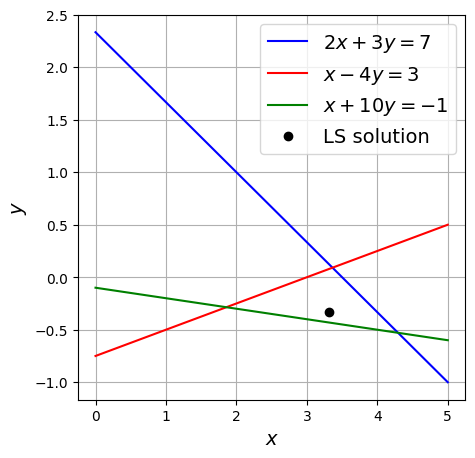

In [13]:

A = np.array([[2, 3], [1, -4], [1, 10]])

# Form the matrix A.T @ A
ATA = A.T @ A

# Form the RHS vector:
rhs = A.T @ np.array([7,3,-1])

# solve the system
ls_sol = sl.solve(ATA, rhs)

# plot this solution to see where it lies

x = np.linspace(0,5,100)

y1 = -(2./3.)*x + (7./3.)
y2 = (1./4.)*x - (3./4.)
y3 = -(1./10.)*x - (1./10.)

fig = plt.figure(figsize=(5, 5))

ax1 = fig.add_subplot(111)

ax1.set_xlabel("$x$", fontsize=14)
ax1.set_ylabel("$y$", fontsize=14)
ax1.grid(True)

ax1.plot(x,y1,'b', label='$2x+3y=7$')
ax1.plot(x,y2,'r', label='$x-4y=3$')
ax1.plot(x,y3,'g', label='$x+10y=-1$')
ax1.plot(ls_sol[0], ls_sol[1], 'ko', label='LS solution')

ax1.legend(loc='best', fontsize=14)

Now, we can look at how our residual norm varies under perturbations that are mutliples of the null space vectors.

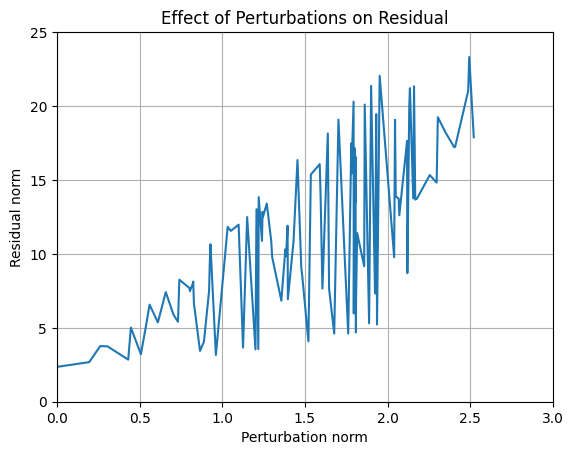

In [14]:
%matplotlib inline
pert = np.random.uniform(-2, 2, size=(100,2))
pert = np.vstack([pert, np.array([0, 0])]) # ensure [0, 0] is checked

b = np.array([7,3,-1])

# compute the 2 norm
residuals = np.array([sl.norm(A@(ls_sol + p) - b) for p in pert])

fig = plt.figure()
ax1 = fig.add_subplot(111)
pert = np.linalg.norm(pert, axis=1) # compute perturbation magnitude

# Sort perturbations and residuals by perturbation magnitude
sorted_indices = np.argsort(pert)  # Get sorting order
sorted_pert_magnitudes = pert[sorted_indices]  # Order perturbation magnitudes
sorted_residuals = residuals[sorted_indices]  # Order residuals accordingly

ax1.plot(sorted_pert_magnitudes, sorted_residuals)
ax1.set_xlabel("Perturbation norm")
ax1.set_ylabel("Residual norm")
ax1.set_title("Effect of Perturbations on Residual")
ax1.set_xlim(0, 3)
ax1.set_ylim(0, 25)
ax1.grid(True)
plt.show()


Above confirms that our solution is infact the minimum solution because perturbing our vector by multiples of the null space basis vectors, while being valid solutions, increase the norm of the residual.


#### Under determined case

A is under determined or fat if $m < n$. Let's look at a specific case

$$\begin{pmatrix}2 & 3 \\ 4 & 6 \end{pmatrix} \begin{pmatrix}x \\ y \end{pmatrix}= \begin{pmatrix} 7 \\ 10\end{pmatrix}$$

Above, notice that the first and second equations have the same LHS. Then our problem asks that for the same $x$ and $y$ one equation satisfies two constraints. There is clearly no solution in this case.

Thus, we seek to find a solution which minimises the residual once again. In the case of an under determined problem, we use the *minimum norm* solution, which is found by solving

$$AA^T \mathbf{x} = A^T \mathbf{b},$$

assuming $(AA^T)^{-1}$ exists.

The minimum norm solution asks of us that we minimise $\mathbf{x}^T\mathbf{x}$ subject to the constraint $A\mathbf{x} = \mathbf{b}$. This is a constrained optimisation problem. Thus, we use the method of Lagrange multipliers. 

The idea behind this is to introduce new variables $\lambda$ which incorporate the constraint into the objective function. The Lagragian function is defined as

$$\mathcal{L}:=\mathbf{x}^T\mathbf{x} - \mathbf{\lambda}^T(A\mathbf{x}-\mathbf{b}).$$

To find the stationary points, we take the derivative w.r.t both $\mathbf{x}$ and $\mathbf{\lambda}$ and set to zero:

$$\nabla_{\mathbf{x}}\mathcal{L} = 0 = 2\mathbf{x}-A^T\mathbf{\lambda},$$

from which we can find that

$$\mathbf{x} = \frac{1}{2}A^T\mathbf{\lambda}.$$

Similarly,

$$\nabla_{\mathbf{\lambda}}\mathcal{L} = 0 = A\mathbf{x}-\mathbf{b}.$$

Now, substituting:

$$A\left(\frac{1}{2}A^T\mathbf{\lambda} \right) = \mathbf{b}$$

$$\Rightarrow \mathbf{\lambda} = 2(AA^T)^{-1}b.$$

And finally back susbtituting to solve for $\mathbf{x}$:

$$\mathbf{x}=\frac{1}{2}A^T\lambda,$$

$$\mathbf{x} = A^T(AA^T)^{-1}\mathbf{b},$$

which is the minimum norm solution.

Let's implement this from an example problem already in RREF, the augmented form of the matrix with zero RHS being

$$
\left(
  \begin{array}{cccc|c}
1 & 0 & 4 & 0 & 0 \\
0 & 1 & -2 & 0 & 0 \\
0 & 0 & 0 & 1 & 0
  \end{array}
\right)$$

The system of equations reads

$$x_1 +4x_3 = 0,$$
$$x_2-2x_3 = 0,$$
$$x_4 = 0.$$

If we set $x_3 = \alpha$ then we find that $x_1 = -4\alpha$ and $x_2 = 2\alpha$ and as such we can write that the solution for $\mathbf{x}$ in the null space is

$$\mathbf{x} = \alpha \begin{pmatrix}-4 \\ 2 \\ 1 \\ 0 \end{pmatrix},$$

or equivalently

$$\mathbf{x} = span \begin{pmatrix}-4 \\ 2 \\ 1 \\ 0 \end{pmatrix}.$$

Any combination of scalar multiples are equally valid solutions to the homogeneous problem, but they will not neccesarily minimise our problem. Let's compute our minimum norm solution in code and use that to check how additions of the basis vectors influence the residual.

In [15]:
# Setting our system
A = np.array([[1, 0, 4, 0], [0, 1, -2, 0], [0, 0, 0, 1]])
b = np.array([1, -2, 3])

# Computing LHS and RHS
AAt = A@A.T
At = A.T

# Now compute the min norm solution
x = At @ sl.inv(AAt) @ b

print(f'Min norm solution: {x}')
print(f'This is a solution: {np.allclose(b, A@x)}')

Min norm solution: [-0.52380952 -1.23809524  0.38095238  3.        ]
This is a solution: True


Text(0.5, 1.0, 'Trade-off Between Solution Norm and Residual Norm')

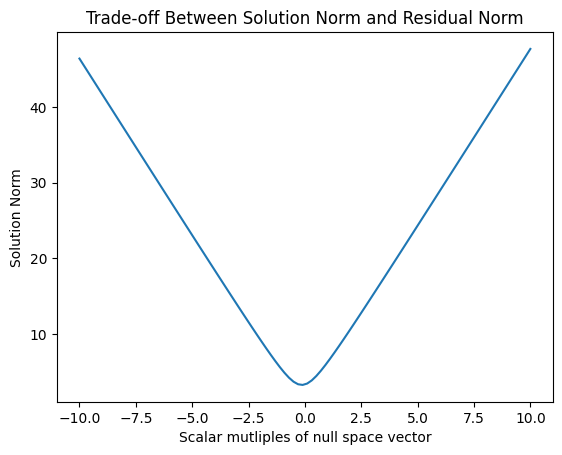

In [16]:
null = np.array([-4, 2, 1, 1])

multiples = np.linspace(-10, 10, 100)

# Compute null space multiple perturbations
sols = [x + mult*null for mult in multiples]
sol_norms = [sl.norm(s) for s in sols]

fig, ax = plt.subplots()
ax.plot(multiples, sol_norms)

# Labels and title
ax.set_xlabel("Scalar mutliples of null space vector")
ax.set_ylabel("Solution Norm")
ax.set_title("Trade-off Between Solution Norm and Residual Norm")

But how can we manually find the minimum norm solution? Let's say we have a system of equations that reads

$$x+y+z=0,$$
$$x+y-z=1.$$

If we subtract the 1st from the 2nd we find that

$$z = -\frac{1}{2},$$

and then both equations read

$$x+y = \frac{1}{2}.$$

Now, if we set $x=\alpha,\ \alpha \in \mathbb{R}$, the solution vector can be written as

$$\begin{pmatrix}x\\y\\z \end{pmatrix}=\begin{pmatrix}\alpha\\\frac{1}{2}-\alpha\\-\frac{1}{2} \end{pmatrix}.$$

Now, the minimum norm solution is 

$$\min(f(\alpha)) = \alpha^2 + \left(\frac{1}{2}-\alpha\right)^2 + \left(-\frac{1}{2}\right)^2,$$

which we can find by computing $f'(\alpha)=0$ as follows

$$f'(\alpha) = 0 = 2\alpha - 2(\frac{1}{2} - \alpha), $$

$$0 =4\alpha - 1, $$

$$\Rightarrow \alpha = \frac{1}{4.}$$

Thus, our solution vector is 

$$\begin{pmatrix}x\\y\\z \end{pmatrix}=\begin{pmatrix}1/4\\ 1/4\\-1/2 \end{pmatrix}.$$

Is this the same as $A^T(AA^T)^{-1}b$? Let's see.

In [17]:
# our example with indpt equations
A = np.array([[1, 1, 1], [1, 1, -1]])
b = np.array([0, 1])

# construct the right hand side:

right = A.T @ np.linalg.inv(A@A.T)

x = right @ b

# print the solution
print(x)

# check that this is a solution:   Ax_m = b?
print(np.allclose(b, A@x))

[ 0.25  0.25 -0.5 ]
True


---

## Lecture 5: Under, Over, and Mixed Determined Problems

Equi determined problmes are

- Square
- Independent
- Consistent

The latter of those three properties means that we cannot derive a contradiction (e.g., arriving at 4 = 0 by means of row operations). The Rouche-Capelli theorem states that any system of equations is inconsistent if the rank of the coefficient matrix is less than that of the augmented matrix, i.e.,

$$Rank([A|b]) > Rank(A),$$

in which case there are no solutions. Furthermore, it details that if

$$Rank([A|b]) = Rank(A),$$

then a unique solution must exist. In this case, there are $k$ free parameters (those which after row reduction you express each variable in terms of) where 

$$k = n - Rank(A),$$

where n is the number of variables (e.g., $x,\ y,\ z$).

For example, take the following system

$$\begin{pmatrix}1&1&1\\1&1&1 \end{pmatrix} \begin{pmatrix} x\\ y\\ z\end{pmatrix} =\begin{pmatrix}0\\1 \end{pmatrix}$$

$$ \Leftrightarrow \left(
  \begin{array}{ccc|c}
1 & 1 & 1 & 0 \\
1 & 1 & 1 & 1 \\
  \end{array}
\right) = [A|\mathbf{b}],$$

which in RREF is

$$ \left(
  \begin{array}{ccc|c}
1 & 1 & 1 & 0 \\
0 & 0 & 0 & 1 \\
  \end{array}
\right) = [A|\mathbf{b}].$$

In this case, $Rank(A)=1$ but $Rank([A|\mathbf{b}]) = 2$ (think $[1,\ 0]^T,\ [0,\ 1]^T$ are linearly indepedent, so 2) and we can clearly see that there is no solution vector can satisfy the augmented form since $0x_3 = 1$ is inconsistent. This is just what the Rouche-Capelli Theorem states.

### A Discussion of Rank

We have seen in previous lectures the cases of over and under determined problems and discussed rank. How do they relate? Well, it turns out that if $A$ is full rank then our system is *purely* determined and we can find an exact fitting solution. Otherwise, no exact solution exists and we must use the least square or minimum norm solution.

Often, however, our problem is simultaneously over and under determined an we call it 'mixed determined'. This can occur with any shape of $A$, but note that if $A$ is mixed determined then $AA^T = 0$ and $A^{-1}$ does not exist. Take for instance

$$\begin{pmatrix}1&0&0\\ 1& 0 & 0 \\ 0 &2 & 2\\ 0&3&3 \\ \end{pmatrix}
\begin{pmatrix}m_1 \\m_2 \\m_3 \end{pmatrix} =
\begin{pmatrix} 1\\2\\2\\3\end{pmatrix}.
$$

This problem is mixed determined because the first two equations read $m_1 = 1$ and $m_1 = 2$, which is an example of under determination, and the third and fourth both read $m_2+m_3 = 1,$ which is an example of over determination.

#### What Should We Do?

In the case that $A$ is mixed determined, we have two options:

- Use the Pseudo inverse $A^+$
- Use a regularisation scheme (e.g., damped L.S soln.)

These have varying use cases. The psuedo inverse is typically expensive to compute and thus is only used in practice for small problems.

#### Decomposition Review

Recall that for $A \in \mathbb{R}^{m\times n}$, the eigenvalues $\lambda$ and vectors $\mathbf{v}$ satsify

$$A\mathbf{v} = \lambda \mathbf{v}.$$

In this case, we can think of the eigenvectors as a special direction in $\mathbb{R^{n}}$ such that pre-multiplication by $A$ does not change the direction of the vector, but only scales it.

Decomposing our matrix in this way allows us to diagonalise it such that we can write it in the form

$$A=P\Lambda P^{-1},$$

where $P$ is a matrix with the eig'vectors as columns and $\Lambda$ is a matrix with the eig'values on its diagonals.

The issue with this is that we can only perform an eigen decomposition on a square system. We can perform an alternative decomposition to obtain analogues of the eigenvalue and vectors using Singular Value Decomposition. This will allow us to find the Pseudo inverse.

Singular values are the square roots of the eigenvalues of the matrix $A^T A$ and $AA^T$. In the square case, all of the diagonals take this value, and in a non-square case the extra eigenvalues are zero. This allows us to write the decomposition as

$$A=U\Sigma V^T,$$

where $U$ is an $m\times m$ whose columns are the eigenvectors of $AA^T$, $V$ is an $n \times n$ orthogonal whose columns are the eigen vectors of $A^T A$, and $\Sigma$ is an $m\times n$ diagonal with entries $\sigma_1, \ \sigma_2, \dots ,$ the singular values.

Now, the general case for computing $A^+$ for an $A$ of any rank is

$$A^+ = \lim_{\lambda \rightarrow 0}(A^T A + \lambda I)^{-1} A^T,$$

where $\lambda$ is a small regularisation parameter. This is closely related to Tikhonov Regularisation and helps in ill-conditioned problems.

#### Relation to the minimum norm solution

Finding the Moore-Penrose inverse allows us to compute the minimum norm solution. If you recall that the minimum norm solution is 

$$\mathbf{x} = (G^TG)^{-1}G^T\mathbf{b},$$

then you should be able to see that, considering we can define $A^+$ to be

$$A^+ = (G^TG)^{-1}G^T,$$

we can write the min norm solution as

$$\mathbf{x}_{\text{min norm}} = A^+\mathbf{b}$$

### Ill-conditioning

In reality, obtained data contain errors. This means that seismic dat aamplify the issue of ill-conditioning, where a small change in $\mathbf{b}$ leads to a large change in $A$, because the small errors that arise naturally from, say, resolution, mislead the change in the model.

Take for instance the following $3\times 3$ tomography problem.

$$\begin{align*}
T_1 &= x_1 + x_2 + x_3\\
T_2 &= x_4 + x_5 + x_6\\
& \vdots \\
T_6 &= x_3 + x_6 + x_9
\end{align*}
$$

and our matrix system is

$$
\begin{pmatrix}
1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots  \\
0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
x_1\\
x_2\\
\vdots \\
x_9
\end{pmatrix}
=
\begin{pmatrix}
T_1\\
T_2\\
\vdots \\
T_6
\end{pmatrix}
$$

Let's say we have a set of travel time measurements $\mathbf{T}$. Due to errors, even if our grid were homogeneous in velocity structure s.t. each travel time should be $6\ s$, our data may look like

$$ \boldsymbol{T} = (6.07, 6.07, 5.77, 5.93, 5.93, 6.03)^T .$$

Now, because $G$ is perfectly symmetrical we require that $T_1 + T_2 +T_3 = T_4 + T_5 + T_6,$ but this is not the case for our slightly skewed data because they contain errors. Thus, with this data there can be no exact solution.

In this case we can use the psuedo inverse to compute an approximate solution as below.

In [18]:
# Alright, let's formulate our problem
G = np.array([[1, 1, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 1, 1, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 1, 1],
              [1, 0, 0, 1, 0, 0, 1, 0, 0],
              [0, 1, 0, 0, 1, 0, 0, 1, 0],
              [0, 0, 1, 0, 0, 1, 0, 0, 1],])

d = np.array([6.07, 6.07, 5.77, 5.93, 5.93, 6.03])

pseudo_G = np.linalg.pinv(G)

x = pseudo_G @ d

print(x)

[2.01111111 2.01111111 2.04444444 2.01111111 2.01111111 2.04444444
 1.91111111 1.91111111 1.94444444]


#### Understanding the tomography problem

Let's explore this problem some more.

In our $3\times 3$ tomography problem, a travel time is acquired by placing a source and receiver at the start and end of each row and column, respectively. Thus, we have 6 travel times. Because the grid is $3\times 3,$ we have 9 slowness values. $G$ then is the $9\times 6$ sensitivity matrix which describes how each of the travel times is sensitive to the slowness $x_i$ of each model cell. Thus our problem can be visualised as such

$$\begin{pmatrix} \\ \\ \\ \\ & & & G & & &\\ \\ \\ \\ \\ \end{pmatrix} \begin{pmatrix} \\ \\ \\ \\ \mathbf{x} \\ \\ \\ \\ \\ \end{pmatrix} = \begin{pmatrix} \\ \\ \\ \mathbf{T}\\ \\  \\ \\  \end{pmatrix}$$

Imagine a $3\times 3$ grid of slowness values like

$$\begin{pmatrix} x_1 & x_2 & x_3 \\ x_4 & \dots & \vdots \\ x_7 & \dots & x_9 \end{pmatrix}$$

$$\Updownarrow$$

$$\mathbf{x} = \begin{pmatrix} x_1 & x_2 & \dots & x_9 \end{pmatrix}^T$$

Imagining our $3\times 3$ grid and looking in more detail, we can see that the ray which traverses the first row is sensitive to $x_1,\ x_2, $ and $x_3$. Thus, the first row of the sensitivity matrix is

$$G_{1:} = \begin{pmatrix} 1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0\end{pmatrix} .$$

Now, more generally we can see that

$$\begin{pmatrix}
1 & 1 & 1 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 1 & 1 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots  \\
0 & 0 & 1 & 0 & 0 & 1 & 0 & 0 & 1
\end{pmatrix}.$$

Do you understand why the last column is as such? Hopefully you can see that the final row represents the ray which traverses the final column and thus that which is sensitive to $x_3, x_6, x_9$ and thus how it is contructed.

Now, remember that in this inverse tomography problem we are trying to assemble a solution model in terms of slowness that results in the measured travel times. However, because the problem is underdetermined we can find infinitely many solutions to satisfy this criterion since there is no 1 unique set of 6 parameters (travel times) that satisfy all 9 equations $G\mathbf{x}$. These solutions will lay in the null space as that is the subspace in which the free parameters that do not change the travel times (reproduce them) lay in.

It is given in this example that one particular solution to this problem is

$$\begin{pmatrix}
2 & 2 & 2 \\
2 & 2 & 2 \\
2 & 2 & 2
\end{pmatrix},$$

but it is also given that two families of solutions within the null space are

$$
\begin{pmatrix}
2+\alpha & 2-\alpha & 2 \\
2-\alpha & 2+\alpha & 2 \\
2 & 2 & 2
\end{pmatrix}, \quad
\begin{pmatrix}
2 & 2 & 2 \\
2 & 2+\beta & 2-\beta \\
2 & 2-\beta & 2+\beta
\end{pmatrix},\quad
$$
where $\alpha$ and $\beta$ are arbitrary constants. Recall that these are some $\mathbf{x}$ which satisfy $G\mathbf{x} = 0$. Here we have represented the solution families as $3\times 3$ matrices, but in reality the solutions are the flattened versions of these which are $9\times 1$ column vectors $\mathbf{x}$, e.g.,

$$\begin{pmatrix}
2+\alpha & 2-\alpha & 2 & 2-\alpha & 2+\alpha & 2 & 2 & 2 & 2
\end{pmatrix}^T .$$

#### Forming a basis vector for the null space

Now, can we find a basis vector? Recall that this is the set of linearly independent vectors which can be written as a linear sum of scalar multiples of the null space vectors. These are the vectors whose scalar multiple may be linearly summed with the particular solution provided above to form a full solution. Thus, it becomes clear from above that a family of full solutions is

$$\mathbf{x} = \begin{pmatrix} 2 \\ 2 \\ 2 \\ 2 \\ 2 \\ 2 \\ 2 \\ 2 \\ 2 \\\end{pmatrix} + \alpha \begin{pmatrix}
1 \\ -1 \\ 0 \\ -1 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\
\end{pmatrix} .$$

The matrix on the far right is our null space basis vector.

#### An important note on the null space of tomography problems

The important thing to recognise here in the context of the problem is that the solution families provided are those which, when combined linearly as scalar multiples, provide a solution to the homogeneous problem $G\mathbf{x}=0.$ These are the solutions which **do not affect travel times**. This becomes more clear when we consider the nature of the matrix multiplication. In this case, $G\mathbf{x}=0$ implies that our solution vector $\mathbf{x}$ are the null space vectors which represent the free parameters. In other words, when we move in a direction $\mathbf{x}$ by any scalar distance in the 9D space defined by $G$, we are moving in a direction in which the travel times do not change. The null space vectors are perpendicular to the directions in which $\mathbf{T}$ varies.

---

Let's explore how we can use a damped least squares solution to minimise this problem.

The damped least squares approach involves minimising the objective function of the form

$$f = ||A\mathbf{x}-\mathbf{b}||^2_2 + \mu ||L \mathbf{x}||^2_2,$$

where $L$ is the identity matrix in damped least squares and a first order derivative operator in Tikhonov Regularisation. In the objective function we use the L2-norm, which is the squared distance between the two vector data sets. For the LS solution, this involves solving the equation

$$\mathbf{x} = (A^T A + \mu I)^{-1} A^T \mathbf{b}.$$

In our case, the problem is

$$\mathbf{x} = (G^T G + \mu I)^{-1} G^T \mathbf{d}.$$

Let's implement this and see how our residual varies for a range of damping factors $\mu$ against our 'absolute' solution we came to by forming the pseudo inverse.

Text(0, 0.5, 'Residual, $|A^{+}\\mathbf{d} - \\mathbf{x}|$')

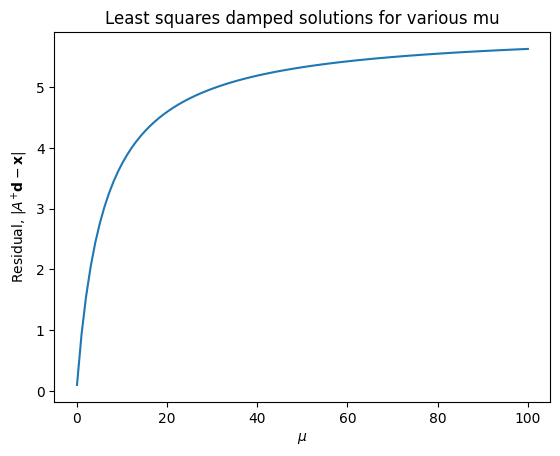

In [19]:
# Let's first assemble a function to compute the least square sol for many mu

def ls_solver(mu):
    I = np.eye(9)
    GtG = G.T @ G
    mueye = mu * I
    Gtd = G.T @ d

    return sl.inv(GtG + mueye) @ Gtd

mu = np.linspace(0.1, 100, 100)

ls_sols = [ls_solver(mew) for mew in mu]

def residual(x, ls_sols):
    gen_inv_norm = sl.norm(x) # Our norm to compare.
    return [gen_inv_norm - sl.norm(sol) for sol in ls_sols]

residuals = residual(x, ls_sols)

# Set up figure
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(mu, residuals)
ax.set_title("Least squares damped solutions for various mu")
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'Residual, $|A^{+}\mathbf{d} - \mathbf{x}|$')


## Understanding column space and linear dependence for square vs. non-square cases

If $A$ is non-square, then we will either have more equations than unknowns or vice versa. 

If $A$ is $\in \mathbb{R}^{3\times 2}$ then there are more equations than unknowns. Let's say we have

$$\begin{pmatrix}\alpha&\beta\\\delta&\gamma\\\phi&\theta\end{pmatrix}\begin{pmatrix}x \\ y \end{pmatrix} = \begin{pmatrix}\eta\\ \mu\\ \tau \end{pmatrix},$$

then $A$ maps $\mathbf{x} \in \mathbb{R}^2$ into $\mathbb{R}^3$. Since we only have 2 columns, we can _at most_ span a plane inside $\mathbb{R}^2$, meaning not every $b\in \mathbb{R}^3$ can be reached by a linear sum of the columns of $A$. We will span a plane if we have two unique directions (linear independence) and a line if we only have one (linear dependence).

If the columns are linearly independent and $\mathbf{b}$ lies in the plane then an exact (unique) solution exists since we can reach it by means of a linear combination of the columns. Then if $\mathbf{b}$ isn't in the plane spanned by the columns no solution exists.  

If they are linearly dependent then one column is just an expression of the other and we only have one truly unique direction, spanning just a line. If $\mathbf{b}$ lies on that line, then there are an infinite number of ways to reach it. If not, there are also no solutions.

Thus, in the over determined situation we have either no solutions, or infinitely many.

The key point here is that linear independence in _square systems_ guarantees the existence of a unique solution since $A \in \mathbb{R}^{n\times n}$ maps $\mathbf{x}$ to $\mathbf{b} \in \mathbb{R}^n$, meaning the column space of $A$ is a 2D real number space, so $\mathbf{b}$ must lay in it, since it also exists in a 2D real number space. On the contrary, linear independence in _non-square systems_ does not guarantee a solution since $A \in \mathbb{R}^{m\times n}$ maps $\mathbf{x}$ to $\mathbf{b} \in \mathbb{R}^m$ and thus $\mathbf{b}$ must exist in the column space of $A$ for there to be a solution. However, this is not guaranteed, and if this is not the case then there are no solutions. If the columns of $A$ are not linearly independent, then there exist no solutions or infinitely many, since even if $\mathbf{b}$ lays on/in the line/plane created by $A$ then there are an infinite number of linear combinations of the columns of $A$ which we can use to reach it and if it does not then we cannot reach it at all.

In the under determined case, say, $A \in \mathbb{R}^{2\times 3}$ then there are 3 columns, each a vector in $\mathbb{R}^2$. There can only be two truly independent vectors in this space, so one of the columns can be expressed as a linear combination of the others. Thus, linear dependence is guaranteed for under determined systems and there must exist zero or infinitely many solutions.

In the over determined case, say, $A \in \mathbb{R}^{3\times 2}$ then 2 vectors exist in the 3D space. While this does not neccasarily guarantee linear dependence, an exact solution is not guaranteed since $\mathbf{b}$ may not exist in the column space of $A$ even if the columns are linearly independent since we cannot span the entire $\mathbb{R}^3$ space with only two vectors. This is the case since $\mathbf{b}$ may lay outside of the plane defined by the column vectors inside of $\mathbb{R}^3$.

In any case, linear dependence guarantees that zero or infinitely many solutions exist because:

- If $\mathbf{b}$ lies inside the space spanned by the dependent columns there are an infinite number of combinations of the columns which can be used to reach it.
- If $\mathbf{b}$ lies outside the span of the columns, there is no solution.

In summary:

1. Linear independence in square systems guarantees a unique solution exists. This is not the case for non-square systems.
2. $\mathbf{b}$ must lay in the column space of $A$ for there to be a solution. Whether that is unique or not depends on whether or not the system is linearly independent or not.
4. Linear dependence in under determined systems is guaranteed since there are more column vectors than the dimension of the column space, meaning one or more columns must be a linear combination of the others.
5. Linear dependence in over determined systems is not guaranteed, since the $n$ column vectors in the $\mathbb{R}^m$ space _may_ be independent.
6. Linear dependence in any case guarantees that there exists either no solutions, or infinitely many.

---

## Lecture 6: Finite Differencing and Devito

Recall that a function $f(x, t)$ has a Taylor series in the spatial domain of

$$f(x + h, t) = f(x, t) + \frac{\partial f}{\partial x}h + \frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2 + \frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\dots.$$

Recognise that our use of a perturbation by $h$ is useful because we can consider how $f$ changes in the sub domain $[x, x+h]$ which is useful for estimating the derivative. By rearranging the above, we can arrive at the first order finite difference approximation, i.e.,

$$\frac{\partial f}{\partial x} = \frac{f(x+h, t) - f(x, t)}{h} - \frac{1}{h}\sum^{\infty}_{n=2}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n.$$

If $h$ is small then the latter term will be small and thus we can say

$$\frac{\partial f}{\partial x} \approx \frac{f(x+h, t) - f(x, t)}{h},$$

where we have an associated error $O$ of

$$O(h^2) = - \frac{1}{h}\sum^{\infty}_{n=2}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n.$$

This is a *forward difference* scheme because its expansion is about $x+h$. In time, we may write

$$\frac{\partial f}{\partial d} \approx \frac{f(x, t+\delta t) - f(x, t)}{\delta t},$$

and hopefully from this it is clear how FD schemes in two variables compare. A *backward difference* scheme may expand about $x-h$, which is also first order accurate. This reads

$$\frac{\partial f}{\partial x} \approx \frac{f(x, t) - f(x-h, t)}{h}.$$

And finally, if we look at $f(x+h, t) - f(x - h, t)$ then we arrive at the *central difference* scheme,

$$\frac{\partial f}{\partial x} = \frac{f(x+h, t) - f(x-h, t) + O(h^3)}{2h}.$$

Notice the $O(h^3)$ term. This indicates that this is a second order method which has improved accuracy owing to the fact that it utilises more terms of the expansions to compute its approximation for the derivative. We can improve our accuracy of the finite difference approximation by incorporating more terms in a similar way, but notice that the number of required computations increases and thus a scheme of higher accuracy is usually more expensive.

The second derivative FD approximation can be writen like

$$\frac{\partial^2 f}{\partial x^2} = \frac{f(x+h, t) -2f(x, t) + f(x-h, t) + O(h^2)}{h^2},$$

and with this in mind we can explore a more specific example.


### Deriving a Time Stepping Scheme

It is our intention in wavefield modelling to discretise the wave equation in such a way that allows us to solve for the entire wavefield on a computational grid using an iterative time-stepping scheme. We can do so by making use of finite difference schemes.

Take, as an initial example, the 2D advection equation which can be written as

$$\frac{\partial u}{\partial t} + c\left(\frac{\partial u}{\partial x} + \frac{\partial u}{\partial y} \right)= 0.$$

We can rewrite the PDE in terms of FD approximations to be

$$\frac{u(x, y, t+\delta t) - u(x, y, t)}{\delta t} = - c\left(\frac{u(x, y, t) - u(x - h, y, t)}{h} + \frac{u(x, y, t) - u(x, y - h, t)}{h} \right),$$

which we can rearange to obtain a forward time stepping scheme in the form of

$$u(x, y, t+\delta t) = u(x, y, t) - c\delta t \left(\frac{u(x, y, t) - u(x - h, y, t)}{h} + \frac{u(x, y, t) - u(x, y - h, t)}{h} \right).$$

### Pure Python Implementation

Let's implement this.



In [20]:
from examples.cfd import plot_field, init_hat # for field visualisation and IC
import numpy as np

In [21]:
# First, setting up our mesh and time stepping parameters

nx = 81 # grid points in x dim
ny = 81 # grid points in y dim

nt = 100 # Number of time steps
c = 1. # advection speed

x_extent = 2.
y_extent = 2.

# mesh spacings
dx = x_extent / (nx - 1)
dy = y_extent / (ny - 1)

print("dx %s, dy %s" % (dx, dy))

sigma = .2
dt = sigma * dx # Time step

dx 0.025, dy 0.025


Now, let's use a top hat function to initialise a disturbance in the field.

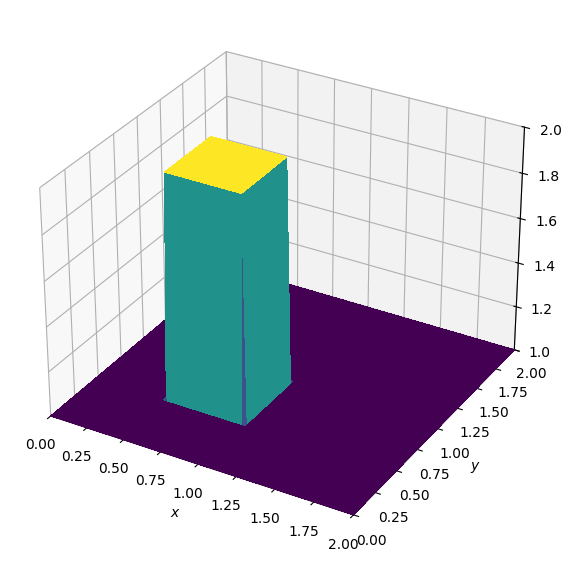

In [22]:
%matplotlib inline

# Create field and assign initial conditions
u = np.empty((nx, ny))
init_hat(field=u, dx=dx, dy=dy, value=2.) # creating an initial distrubance in the field

# Plot initial condition
plot_field(u)

And now we can implement our FD scheme subject to the following BCs

$$u(0, y, t) = u(2, y, t) = u(x, 0, t) = u(x, 2, t) = 1$$

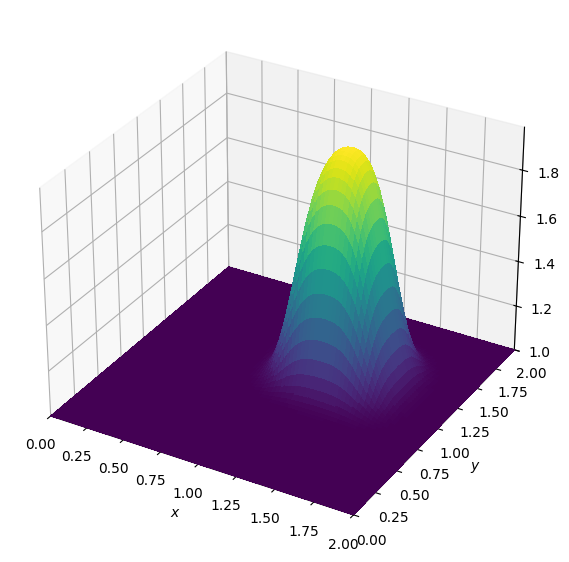

In [23]:
%matplotlib inline

# Repeat initialisation, so we can re-run the cell
init_hat(field=u, dx=dx, dy=dy, value=2.)

# Time-stepping loop
for t in range(nt):
    prev_u = u.copy()  # Previous time step's values (u_n)

    # Compute the finite difference update
    for i in range(1, ny):
        for j in range(1, nx):
            delta_x = prev_u[i, j] - prev_u[i-1, j] # First stencil
            delta_y = prev_u[i, j] - prev_u[i, j-1] # Second stencil

            u[i, j] = prev_u[i, j] - (c * dt / dx) * delta_x - (c * dt / dy) * delta_y

    # Apply boundary conditions (keep them fixed at 1)
    # Note: these are Dirichlet, since u is always specified at the boundaries
    u[0, :] = 1.   # Left boundary
    u[-1, :] = 1.  # Right boundary
    u[:, 0] = 1.   # Bottom boundary
    u[:, -1] = 1.  # Top boundary

plot_field(u)

Note above we observe *numerical diffusion*. This is the smoothing effect visible when compared to the IC plot that is caused by the relatively high error of the first order scheme we employed. The effect of this is a dampening of high frequency components such that the advection equation behaves more like the advection-diffusion equatio n.

We may also see dispersion, where different Fourier modes propagate at different speeds leading to oscillations near the edges of the function. We will see more on this later.

### A Word on The Order of Things

Notice how the above takes a step-by-step approach to solving the problem. This is useful and will benefit you, especially in solving problems using Devito. A simple general order of events may be taken as follows

1. Define our spatial mesh
2. Define our wavefield
3. Set and invoke initial conditions
4. Solve iteratively for the wavefield, applying BCs at each time step

Keep this in mind for the next section.

### Devito Implementation

Devito is both a DSL and compiler that was developed in house and specialises in solving finite difference problems. It comes with a suite of functionality and heavily subclasses SymPy for symbolic representations of our finite difference schemes. Let us quickly jump in with a practical example of how we can implement a new problem.

Note that Devito can be freely accessed via `!pip install devito`, but to do so locally you must make use of WSL and have Hyper-V enabled. If this is not an option, make use of Colab.

An exact traveling wave solution to the 1-dimensional wave-equation,

$$\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}=0,$$

on the interval $x\in[0,1]$ with $c=1$ is given by:

$$u(x,t)=\left[\mathrm{max}(0,4\zeta(1-\zeta))\right]^{12},$$

where

$$\zeta=4(x-ct)-1,$$

subject to the boundary conditions $u(0,t)=u(1,t)=0$.

Let's compose a Devito operator to solve this problem.

In [24]:
pip install devito 

Note: you may need to restart the kernel to use updated packages.


In [25]:
# Install neccesary functions
from devito import Grid, Function, TimeFunction, Eq, Operator, solve
import matplotlib.pyplot as plt
import numpy as np

In [26]:
# Define our mesh parameters

nx = 201  # Number of grid points in space
x_extent = 1.
dx = x_extent / (nx - 1)  # Spatial step size

nt = 201  # Number of time steps
dt = 0.001  # Time step size (small for stability)

In [27]:
# Create mesh
grid = Grid(shape=(nx), extent=(1.0))  # 1D grid from x=0 to x=1

x = np.linspace(0, x_extent, nx) # for generating ICs
t = grid.stepping_dim # to ensure BC invoked at every time step

In [28]:
# Define the wavefield

u = TimeFunction(name="u", grid=grid, time_order=2, space_order=4)

In [29]:
# functions to compute the absolute solution (& initial condition)
def compute_zeta(x,t):
    return 4.0*(x-t)-1.0

def compute_u(x,t):
    u1 = 4.0*compute_zeta(x,t)*(1.0-compute_zeta(x,t))
    u2 = np.zeros(u1.shape)
    return (np.maximum(u1,u2))**(12)

In [30]:
# Define the equation

c = 1.
pde = (1/c**2) * (u.dt2-u.dx2) # wave eq

stencil = solve(pde, u.forward)
eq = Eq(u.forward, stencil) # This is our FD update scheme

In [31]:
# Define initial condition

u_0 = Function(name='u_0', grid=grid)
u_0.data[:] = compute_u(x, 0)

In [32]:
# Apply BCs & IC

bc = [Eq(u[t+1, 0], 0)]
bc += [Eq(u[t+1, nx-1], 0)]

# Set the initial conditions
u.data[0,:] = u_0.data[:]
u.data[1,:] = compute_u(x,dt)

In [33]:
# Create the Devito operator and solve

op = Operator([eq]+bc)
op.apply(time_m=1, time_M=1999, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.00012399999999999976, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Now, consider what we have simulated here. We have a 1D spatial domain $x \in [0,\ 1]$ within which a spike pulse has travelled for 2 units of time. Our boundary conditions are set such that the displacement at the boundaries are zero, meaning the wave is reflected at the boundary. The wave is not subject to dispersion, so its shape does not change .Considering we set $c=1.0,$ the wave travels 1 unit of space in 1 unit of time. This means that in the 2 units of time which we simulated the wave should have  travelled to the right, reflected, and returned to its original position. Thus, we should see the state of the system at $t=2$ matches the intiial condition. Let's plot this to investigate.

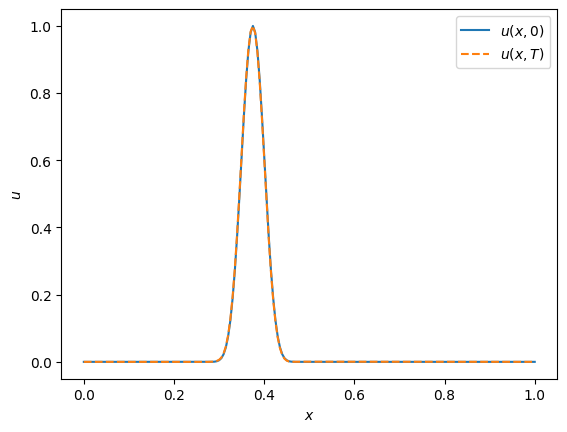

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(x, u_0.data[:], label = "$u(x,0)$")
plt.plot(x, u.data[0, :], label = "$u(x,T)$", linestyle='--')
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.legend()
plt.show()

Success!

---

The above involves a simple case of Dirichlet boundary conditions, where the field is specified at the boundary. Let's look at a more interesting case where we have both Dirichlet and Neuman conditions (mixed).

Consider the following boundary value problem for the 1D wave equation:

\begin{align}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}(x,t)-\frac{\partial^2 u}{\partial x^2}(x,t)&=0, \\
  u(0,t)=u(10,t)&= 0, \\
  \frac{\partial u}{\partial t}(x,0)&=0, \\
  u(x,0)&=
    \begin{cases}
      0, & 0 \leq x < 4,\\
      1, & 4 \leq x \leq 6,\\
      0, & 6 < x \leq 10.
    \end{cases}
\end{align}

The initial state is illustrated in the figure below:

<img src="https://github.com/nocturnal-luke/Geophysical-inversion-undergraduate/blob/main/lectures/L5/figures/exact_solution.png?raw=1" width="550" height="450" align="center"/>

Let's compose a finite differencing scheme to solve this problem.

The  wave equation can be written as

$$u_{tt} = c^2 u_{xx}$$

and the 2nd temporal and spatial derivatives are

$$\frac{\partial^2 u}{\partial x^2} = \frac{u_{x+1}^t - 2u_x^{t} + u_{x -1}^{t}}{\Delta x^2},$$

and

$$\frac{\partial^2 u}{\partial t^2} = \frac{u_{x}^{t+1} - 2u_x^{t} + u_{x}^{t-1}}{\Delta t^2},$$

where we have denoted $u(x+h, t)$, for the increment $h$, as $u_{x+1}^{t}$ and similarly for an increment in time. Now we can fully discretise the 1D acoustic wave equation to form a time stepping scheme, i.e.,

$$u_x^{t+1} = 2u^t_x - u^{t-1}_{x} + c^2 \frac{\Delta t^2}{\Delta x^2}(u_{x+1}^t - 2u_x^{t} + u_{x -1}^{t}).$$

Let's implement this.

In [35]:
# First, defining our mesh & other parameters

L = 10 # length of domain

nx = 1001 # number of mesh nodes
dx = L / (nx - 1) # mesh spacing

nt = 8000
c = 1. # wavespeed
dt = 0.5 * dx/c # size of time steps

In [36]:
# Defining our wavefield
u = np.zeros((nx, nt))

In [37]:
# Setting our Dirichlet IC

for i in range(nx):
    x = i * dx
    if 4 <= x <= 6:
        u[i, 0] = 1.0  # Initial displacement

 Now, recognise that our BCs are mixed and we thus must implement a finite difference stencil to specify the Neuman condition in our code. Note, this condition implies that the initial wavespeed is zero.

 Discretised, the Neuman condition reads

$$\frac{\partial u}{\partial t} \approx \frac{u_{x}^{t+1} - u^t_x}{\Delta t} = 0,$$

which we can rearrange to be

$$u_x^{t+1} = u_x^t .$$

This is simple to implement as below.

In [38]:
u[:, 1] = u[:, 0] # Neuman portion

Text(0.5, 1.0, '$u(x, 0)$')

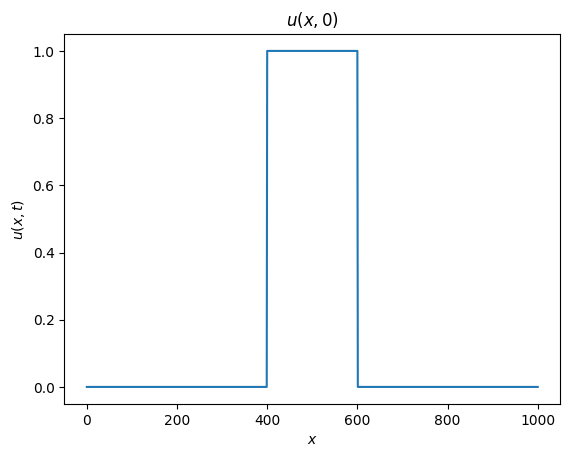

In [39]:
# Plotting our IC

plt.plot(u[:,0])
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')
plt.title('$u(x, 0)$')

In [40]:
# Implementing our FD scheme

for T in range(1, nt - 1):
  for X in range(1, nx - 1):
    delta_x = u[X+1, T] - 2*u[X, T] + u[X-1, T]
    const = c**2 * (dt**2 / dx**2)

    u[X, T+1] = 2*u[X, T] - u[X, T-1] + (const * delta_x)

Text(0, 0.5, '$u(x, t)$')

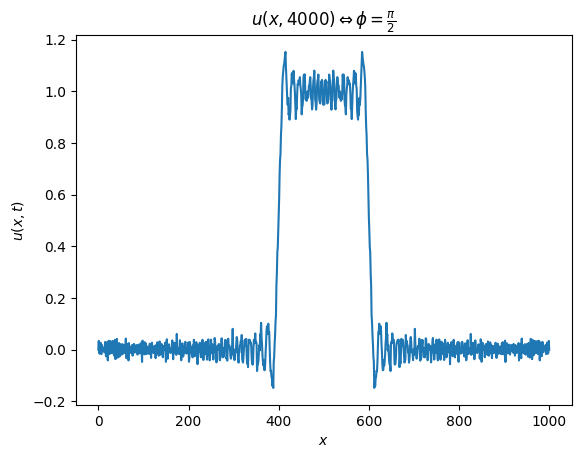

In [41]:
# And plotting at the half-cycle point

plt.plot(u[:,-4000])
plt.title(r'$u(x, 4000) \Leftrightarrow \phi = \frac{\pi}{2}$')
plt.xlabel('$x$')
plt.ylabel('$u(x, t)$')

We can see how our solution varies through time as below.

![Wave Equation Animation](https://github.com/nocturnal-luke/Geophysical-inversion-undergraduate/blob/main/figures/wave_eq.gif?raw=1)

Let's code this up using Devito.

In [1]:
from devito import Grid, Eq, TimeFunction, Operator

In [43]:
# Define mesh parameters
nx = 1001 # number of nodes
nt = 4000 # number of time steps
x_extent = 10 # physical x extent

dx = x_extent / (nx-1) # mesh spacing
dt = 0.004 # size of time steps

In [44]:
# Set up mesh
grid = Grid(shape=(nx), extent=(x_extent))

t = grid.stepping_dim # ensure BC applied at each time step from inside .apply

In [45]:
# Define our wavefield

u = TimeFunction(name="u", grid=grid, time_order=2, space_order=2)

In [46]:
# Define the equation

c = 1.
pde = (1/c**2) * (u.dt2-u.dx2) # wave eq

stencil = solve(pde, u.forward)
eq = Eq(u.forward, stencil) # This is our FD update scheme

In [47]:
# Define IC

u_0 = Function(name='u_0', grid=grid)
u_0.data[400:600] = 1.

In [48]:
# Apply BCs and ICs

bc = [Eq(u[t + 1, 0], 0)]
bc += [Eq(u[t + 1, -1], 0)]

# Set the ICs
u.data[0, :] = u_0.data[:]
u.data[1,:] = u.data[0, :]

In [49]:
# Generate the operator and apply
op = Operator([eq]+bc)
op.apply(time_m = 1, time_M = 4999, dt=dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000893000000000014, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

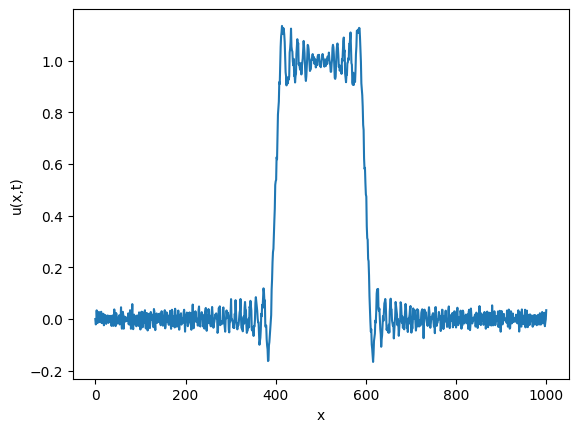

In [50]:
# Plot the half-cycle point

%matplotlib inline
plt.plot(u.data[-1, :])
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.show()

### On Numerical Dispersion

Above we can see numerical dispersion. We can see how the effect of this varies by changing the space order parameter or our mesh node number.

We have talked repeatedly about numerical dispersion but never really clarified how we can avoid it. Numerical dispersion is an artefact of FD solutions to the wave equation which propagate some frequencies at different wavespeeds. This is a direct result of our approximation of a continuous function with a discrete one.

Some key causes of numerical dispersion incude:

- Finite grid spacing
- Time discretisation
- Truncation error (of the Taylor series)
- Stability constraints

The latter of the above relates to the Courant-Friedrichs-Lewy (CFL) condition. This is a fundamental stability criterion for numerical solutions of PDEs. It ensures that numerical wave propagation remains stable and physically meaningful by constraining the time step size $\Delta t$ relative to the mesh spacing $\Delta x$. In the case of the 2D advection equation, this criterion is

$$c\frac{\Delta t}{\Delta x} + c\frac{\Delta t}{\Delta y} \le 1,$$

and for the 1D wave equation we have that

$$c\frac{\Delta t}{\Delta x} \le 1.$$

When we set our time step size we can invoke this using something like

`dt = 0.5 dx/c`

which ensures that the criterion is enforced no matter the mesh spacing.

---

## 7: 2D Wave Propagators

The process we are trying to model is a seismic survey, so we must account for source injection and reciever positionining when we are modeling. We need to solve the wave equation and implement source and receiver interpolation to inject the source and records the seismic wave at sparse locations on the grid.

For slowness $m$ and a source $q$ the wave equation is

$$\begin{cases}
 &m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) = q \ \text{in } \Omega \\
 &u(\mathbf{x},t=0) = 0 \\
 &\frac{\partial u(\mathbf{x},t)}{\partial t}|_{t=0} = 0 
\end{cases}$$

where the zero ICs guarantee uniqueness. However, in discretising our equation we must consider that our domain is finite. Thus, our boundary conditions must represent the fact that our wave does not reflect at the sides and bottom of our domain, but continues to propagate. We can do so by implementing an Absorbing Boundary Condition (ABC) controlled by the damping mask $\eta$ which dictates how waves are effectively attenuated at the margins of our domain. The acoustic wave equation with this BC is 

$$\begin{cases} 
 &m \frac{\partial^2 u(\mathbf{x},t)}{\partial t^2} - \nabla^2 u(\mathbf{x},t) + \eta \frac{\partial u(\mathbf{x},t)}{\partial t}=q  \ \text{in } \Omega \\
 &u(\mathbf{x},0) = 0 \\
 &\frac{\partial u(\mathbf{x},t)}{\partial t}|_{t=0} = 0 
\end{cases}.$$

### Seismic modelling with Devito

As always, our first step is to define the physical dimensions of our problem. We will consider a simple two layer model with an upper velocity of $1.5kms^{-1}$ and a lower of $2.5 kms^{-1}$.


Operator `initdamp` ran in 0.01 s


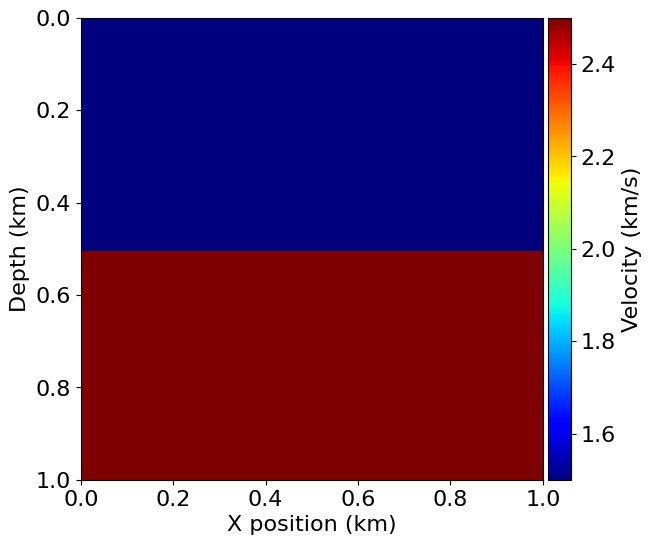

In [51]:
from examples.seismic import Model, plot_velocity
import numpy as np

# Define a physical size
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :51] = 1.5
v[:, 51:] = 2.5

# With the velocity and model size defined, web can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)

Next, we must define our acquisition geometry. First, we define our source, a so called Ricker wavelet of the form

$$q(t)=\left(1-2\pi^2f^2_0\left(t-\frac{1}{f_0}\right)^2\right)e^{-\pi^2f^2_0\left(t-\frac{1}{f_0} \right)}.$$

In order to include such a signature, we first need to define the duration of our model and the timestep size, which is dictated by the CFL condition. Luckily, `Model` provides this such that we can fully discretise our model time axis as an array as below.

In [52]:
from examples.seismic import TimeAxis

t0 = 0. # start at t=0
tn = 1000. # 1000ms
dt = model.critical_dt

time_range = TimeAxis(start=t0, stop=tn, step=dt)

Now we can position the source. Below, it is at a depth of $20m$ and in the centre of the $x$ axis with a peak frequency of $10Hz$.

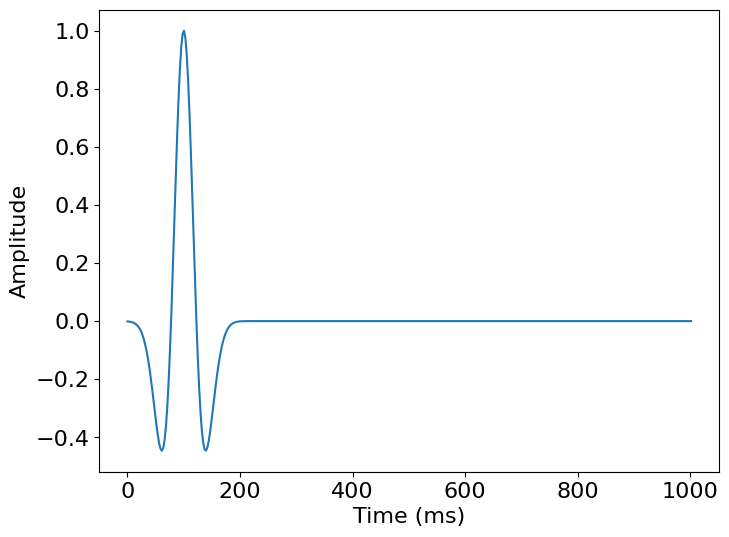

In [53]:
from examples.seismic import RickerSource

f0 = 0.010  # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# Set source coordinates
src.coordinates.data[0, 0] = np.array(model.domain_size[0]) * .5
src.coordinates.data[0, 1] = 20.  # Depth is 20m

# We can plot the time signature to see the wavelet via:
src.show()

With our source injection defined, we must define our receiver geometry. For this, we can use a symbol of type `Receiver`. We will plot the receivers at the saem depth as the source every $10m$ along the $x$ axis. Note that following this `rec.data` is initialised but empty. We will fill the record when we compute the reciever readings during the simulation.

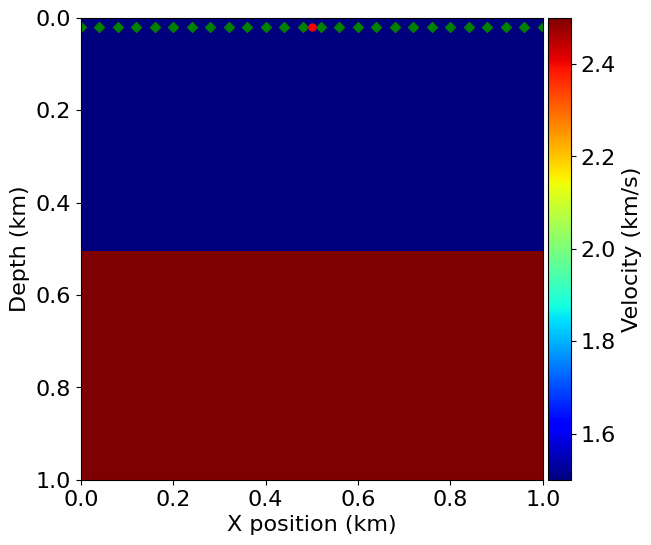

In [54]:
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 20.  # Depth is 20m

# We can now show the source and receivers within our domain:
# Red dot: Source location
# Green dots: Receiver locations (every 4th point)
plot_velocity(model, source=src.coordinates.data,
              receiver=rec.coordinates.data[::4, :])

From now on, we will only consider 2nd order time discretisation. From the Taylor expansion, the second order time derivative is

$$\frac{\partial^2 u(x, t)}{\partial t^2} = \frac{u(x, t+\delta t) - 2u(x, t) + u(x, t-\delta t)}{\delta t^2} + O(\delta t^2).$$

In space, we make use of the Laplacian. This is the discretised version of $\nabla^2 u(x, t)$ which is represented as the sum of the second order spatial derivatives in 3 dimensions:

$$ \begin{aligned}
\Delta u(x, y, z, t) = \sum_{j=1}^{k/2} \left[ 
\alpha_j \left( 
u(x + j\,dx, y, z, t) + u(x - j\,dx, y, z, t) + \\
u(x, y + j\,dy, z, t) + u(x, y - j\,dy, z, t) + \\
u(x, y, z + j\,dz, t) + u(x, y, z - j\,dz, t) 
\right) + \\ 
3\alpha_0 u(x, y, z, t)
\right] \end{aligned}
$$


where $\alpha_j$ are the approximate finite difference weights for the approximation. This is all wrapped by Devito in `u.laplace`.

With the space and time discretisation defined, we can fully discretise the wave equation with teh combination of the time and space discretisations to obtain the following stencil (2nd order in time, $k$ in space)

$$u(x, y, z, t+\delta t) = 2u(x, y, z, t)-u(x, y, z, t-\delta t)+\frac{\delta t^2}{m(x, y, z)}\left(\Delta u(x, y, z, t) + q(x, y, z, t)\right).$$

Remember, $m:= \frac{1}{c^2}$ and $q$ is our source wavelet function.

In [55]:
from devito import TimeFunction

# define the wavefield:
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

In [56]:
# and now our pde
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
pde

damp(x, y)*Derivative(u(t, x, y), t) - Derivative(u(t, x, y), (x, 2)) - Derivative(u(t, x, y), (y, 2)) + Derivative(u(t, x, y), (t, 2))/vp(x, y)**2

In [57]:
from devito import solve, Eq

In [58]:
# and we can finally obtain our update scheme from the stencil
stencil = solve(pde, u.forward)
update_scheme = Eq(u.forward, stencil)

Now, we must go about injecting our source. Using the above wave equation form (which is semi discretised and includes a source perturbation) we need to inject the value of the source at time $t$ in order to evaluate $u$ at a time $t+\delta t$. Note that our source may not be injected directly on a node. Thus we must linearly interpolate the source value between the proximal nodes. 

In [59]:
# Finally we can define the source injection
src_term = src.inject(field=u.forward, expr=src*dt**2/model.m)

# and an interpolation expression for the receivers
rec_term = rec.interpolate(expr=u.forward)

At last we have what we need to create our Devito operator and run.

In [60]:
from devito import Operator
op = Operator([update_scheme] + src_term + rec_term, susb=model.spacing_map) # final kwarg reduces number of flops

Let's first run for a few timesteps and visualise the wavefield.

In [61]:
op(time=100, dt=model.critical_dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0005910000000000006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=4e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=6.89999999999999e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

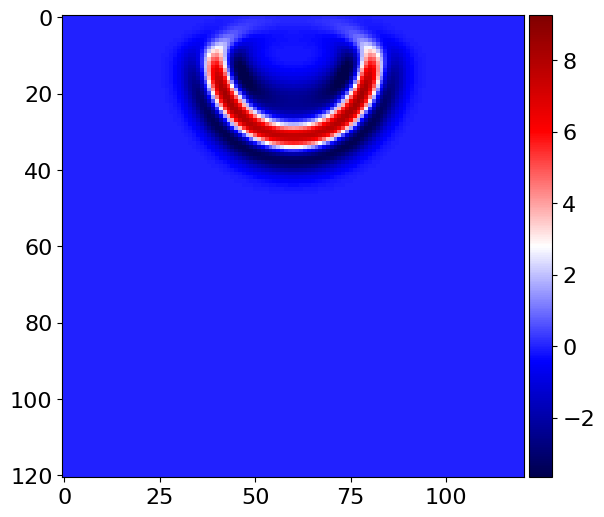

In [62]:
from examples.seismic import plot_image
plot_image(u.data[0, :, :], cmap="seismic")

Cool. Let's reset the wavefield and run the simulation for its full duration.

In [63]:
u.data[:] = 0.
op(time=time_range.num-1, dt=model.critical_dt)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.003450000000000011, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=2.0000000000000005e-05, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0002880000000000005, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

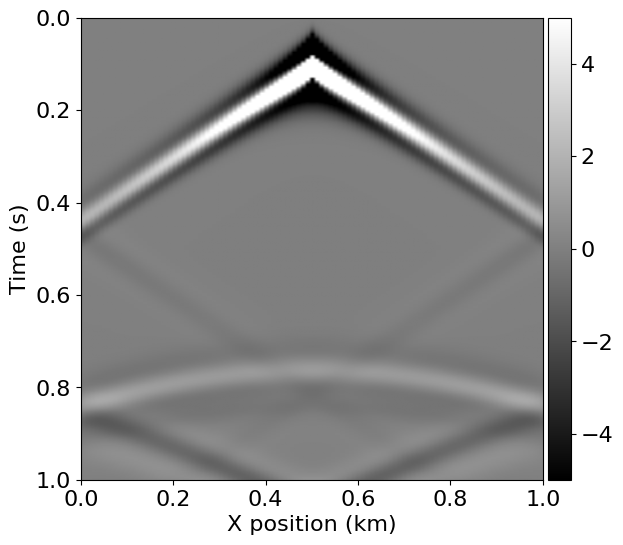

In [64]:
from examples.seismic import plot_shotrecord
plot_shotrecord(rec.data, model, t0, tn)

## Lecture 8: FWI Implementation

In the previous lecture, we learnt to build a 2-dimensional domain, discretise it in time and space, and apply a discretisation of the wave equation (including a source term) to our model to produce a shot record. This forward modelling is the first step of the FWI process. So, what's next?

FWI requires field data and an initial velocity model $m_0$. The forward problem is solved in order to create a synthetic data set against which the objective function may be evaluated. We do this with teh method of steepest descent which, in its simplest form, is

1. evaluate the gradient function $\nabla \phi(m)$ of the current model
2. find the step length $\alpha$
3. subtract $\alpha$ times the gradient from the current model to to obtain a new model
4. iterate until the objective function is suitably small

which is all to say that we need to implement the scheme

$$m_{n+1} = m_n - \alpha \nabla_m f.$$

We will keep our experiment small, since FWI is very expensive. Let's define our running parameters to reflect this.

In [297]:
nshots = 9  # Number of shots to used to generate the gradient
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 15  # Number of outer FWI iterations

### Models

In this case, we will use a very simple domain model of a circle within a 2D domain. This will be used as our "true" model and a constant velocity background will be our initial model $m_0$. 

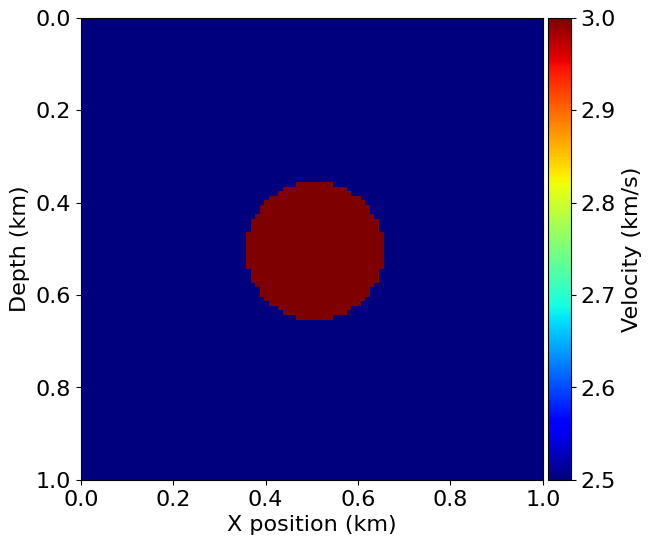

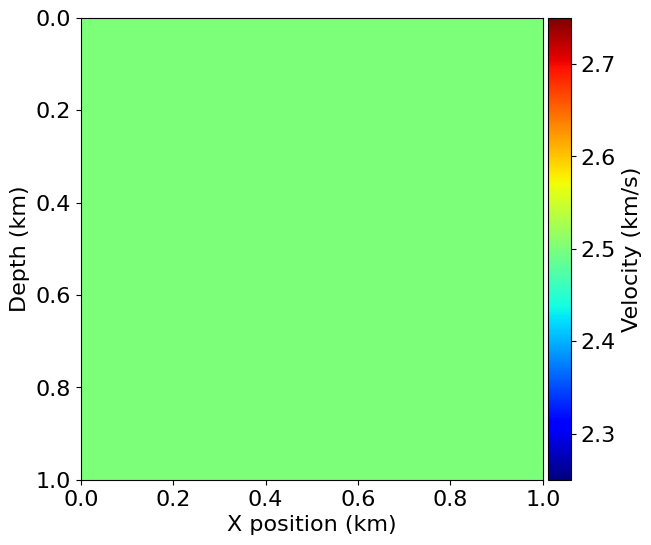

In [345]:
from examples.seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

# True model - Used to generate the 'field' data
model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

# Smooth (initial) model - Used to generate our model/synthetic data
model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                    grid = model.grid)

plot_velocity(model)
plot_velocity(model0)

### Acquisition Geometry

In this example, we will use a 'transmission experiment' source receiever setup, akin to a cross hole imaging setup. Let's define our source and receiver geometry below.

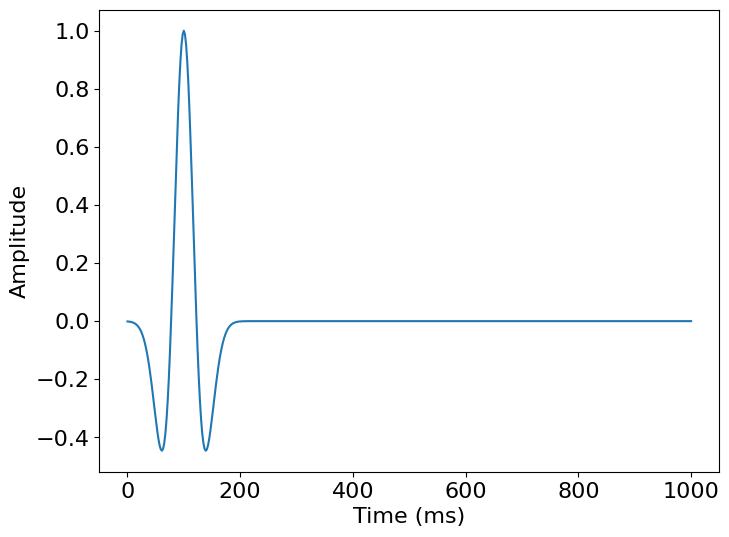

In [346]:
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry

t0 = 0.
tn = 1000. 
f0 = 0.010
# Position the source:
src_coordinates = np.empty((1, 2))
src_coordinates[0, 1] = np.array(model.domain_size[1]) * .5
src_coordinates[0, 0] = 20.

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

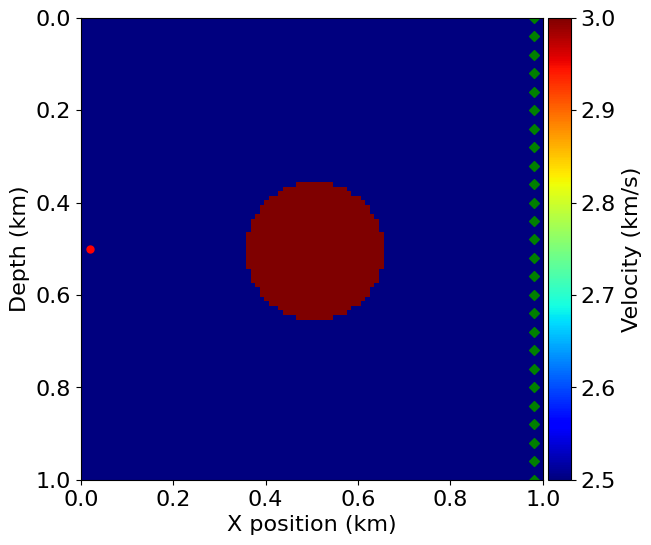

In [347]:
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions, receiver=geometry.rec_positions[::4 ,:])

### 'True' and 'Synthetic' Data

We can generate shot records for our 'true' and initial model, to begin with. This will allow us to compute a residual.

In [301]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=model.vp)

In [302]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

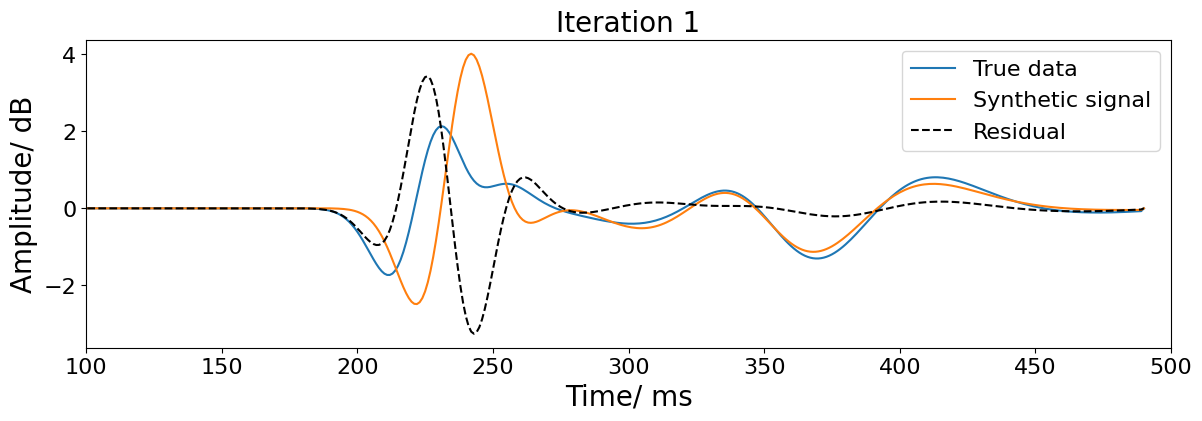

In [303]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,4))
ax1.plot(true_d.data[:, 50], label='True data')
ax1.plot(smooth_d.data[:, 50], label='Synthetic signal')

residual = (true_d.data[:, 50] - smooth_d.data[:, 50])
ax1.plot(residual[:], label='Residual', linestyle ='--', color='k')

ax1.set_xlabel('Time/ ms', fontsize=20)
ax1.set_ylabel('Amplitude/ dB', fontsize=20)
ax1.set_xlim(100, 500)
ax1.set_title('Iteration 1', fontsize=20)
ax1.legend()

Now let's see what our true shot record looks like...

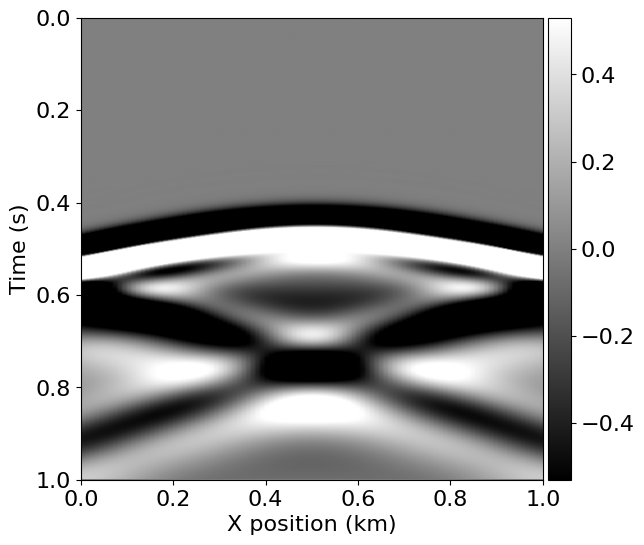

In [304]:
from examples.seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)

... and our synthetic...

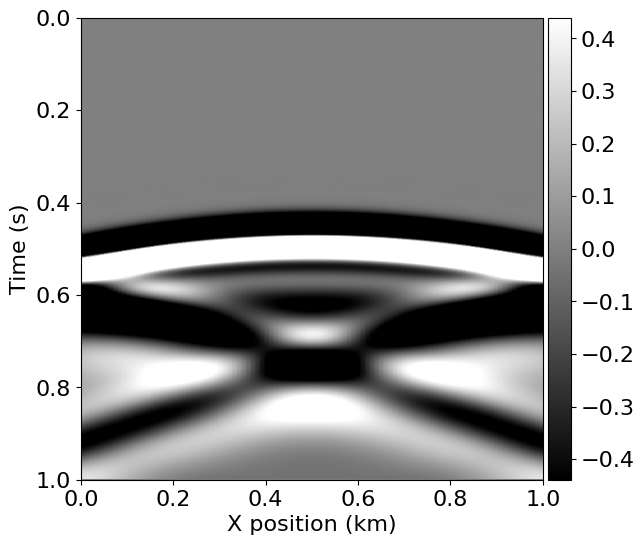

In [305]:
plot_shotrecord(smooth_d.data, model, t0, tn)

... and finally our residual.

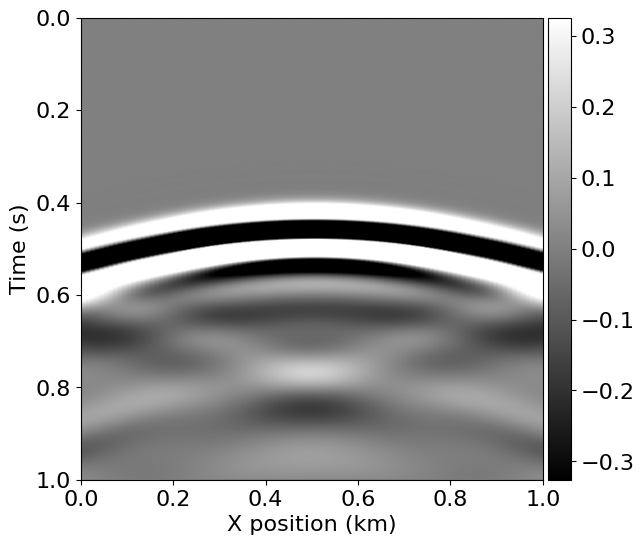

In [306]:
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

### Formulation

Our objective function is chosen to be the $L_2$ norm of the residual data, i.e.,

$$\phi (m) = \frac{1}{2}||p-d||^2 = \frac{1}{2} \sum_{n_s}\sum_{n_r}\sum_{n_t}|p-d|^2,$$

where $s,\ r,$ and $t$ denote the number of shots, receivers, and time samples. This is the function we seek to minimise. Our steepest descent loop in this case is

$$\nabla \phi(m) = \frac{\partial f}{\partial m} = -u^T\left(\frac{\partial A}{\partial m}\right)^T\delta u,$$

where $\delta u$ is the residual wavefield. To compute the gradient, we use `solver.forward` to compute the entire forward wavefield and a similar operator to compute the adjoint wavefield. Our solver also computes teh correlation between the wavefields. Next, we back propagate the data residual for multiple source positions which are summed to obtain a gradient image of the subsurface. Let's initialise our source locations.

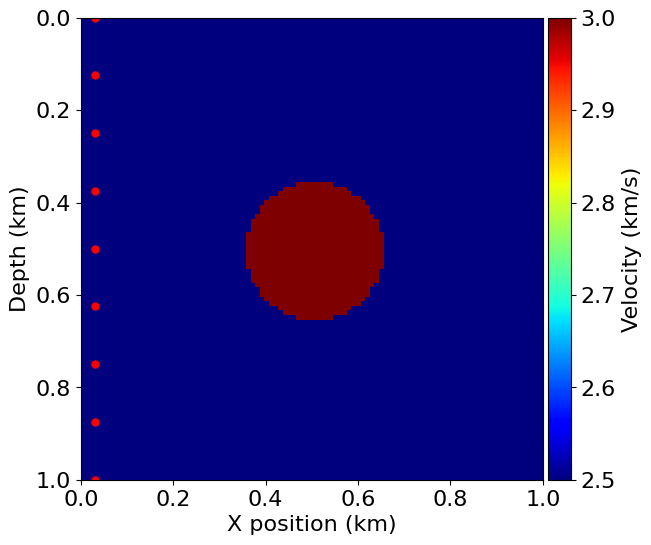

In [307]:
# Prepare the varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

Now, let's write a function to compute the residual.

In [308]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual

And finally we are ready to formulate the FWI kernel.

In [309]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid, time_range=geometry.time_axis, coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid, time_range=geometry.time_axis, coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid, time_range=geometry.time_axis, coordinates=geometry.rec_positions)
    objective = 0.
    
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        
        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, grad, d_syn

### Model updates

Having defined our FWI gradient procedure, we can compute the initial iteration from our starting model which will allow us to visualise the gradient, model perturbation, and effect of the gradient update.

In [310]:
from devito import configuration
configuration['log-level'] = 'WARNING' # This added simply to reduce clutter in the output

In [311]:
# Compute gradient of initial model
ff, update, d_syn = fwi_gradient(model0.vp)
assert np.isclose(ff, 57283, rtol=1e0)

In [313]:
from devito import mmax
from examples.seismic import plot_image

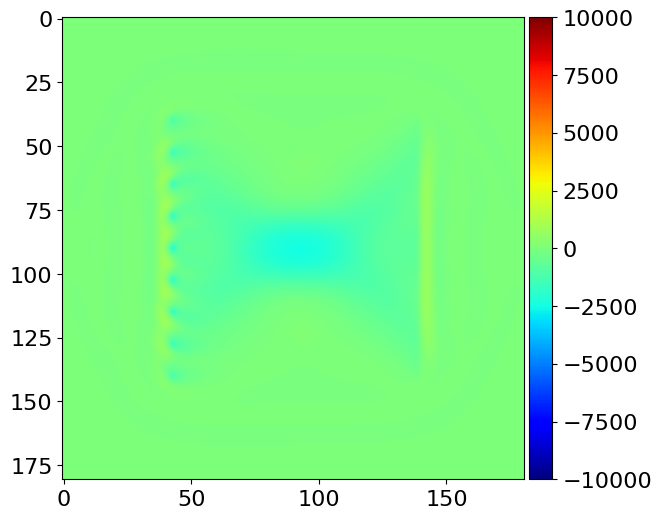

In [351]:
# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

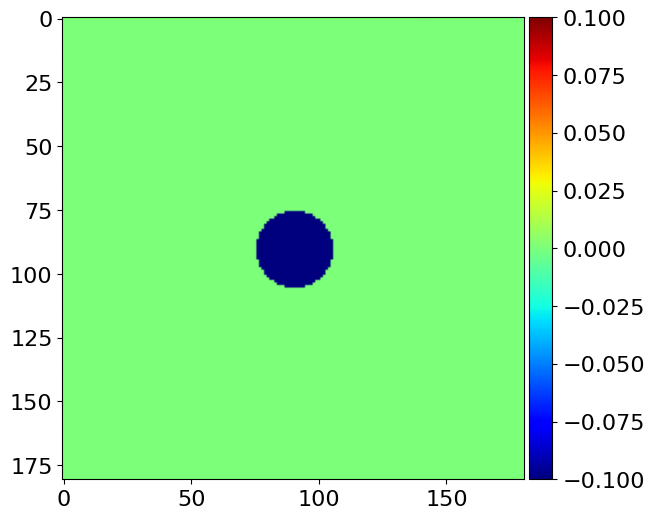

In [315]:
# and the residual
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

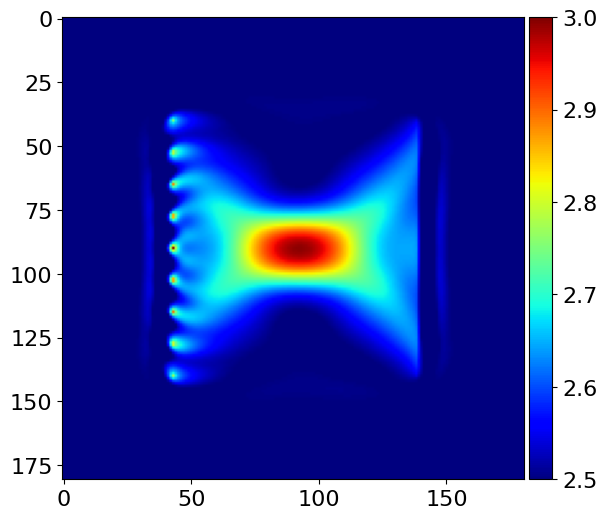

In [316]:
# and finally the effect of the model perturbation
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

### Gradient descent

First, we will define a function which applies a model update bounded by velocity constraints.

In [317]:
from sympy import Min, Max

# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

And a loop to run the scheme in its entirety. Note in this case we have enforced an artificial fixed step length. In more proper projects this would be replaced by a line search method to find the optimal step size.

In [318]:
# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
synth = np.zeros((fwi_iterations, 491))

for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction, d_syn = fwi_gradient(model0.vp)
    
    synth[i, :] = d_syn.data[:, 50]
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    alpha = .05 / mmax(direction)
    
    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))
    if phi < 50:
        break

Objective value is 39293.324219 at iteration 1
Objective value is 24506.767578 at iteration 2
Objective value is 14386.490234 at iteration 3
Objective value is 7907.372559 at iteration 4
Objective value is 3959.944092 at iteration 5
Objective value is 1612.906494 at iteration 6
Objective value is 586.379272 at iteration 7
Objective value is 716.316040 at iteration 8
Objective value is 32521.943359 at iteration 9
Objective value is 14118.518555 at iteration 10
Objective value is 2411.918457 at iteration 11
Objective value is 1240.301514 at iteration 12
Objective value is 31210.695312 at iteration 13
Objective value is 10876.838867 at iteration 14
Objective value is 296.122131 at iteration 15


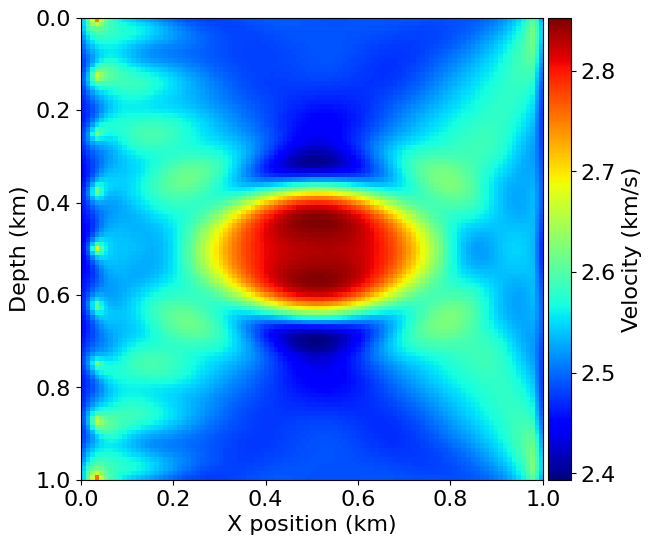

In [319]:
# Plot inverted velocity model
plot_velocity(model0)

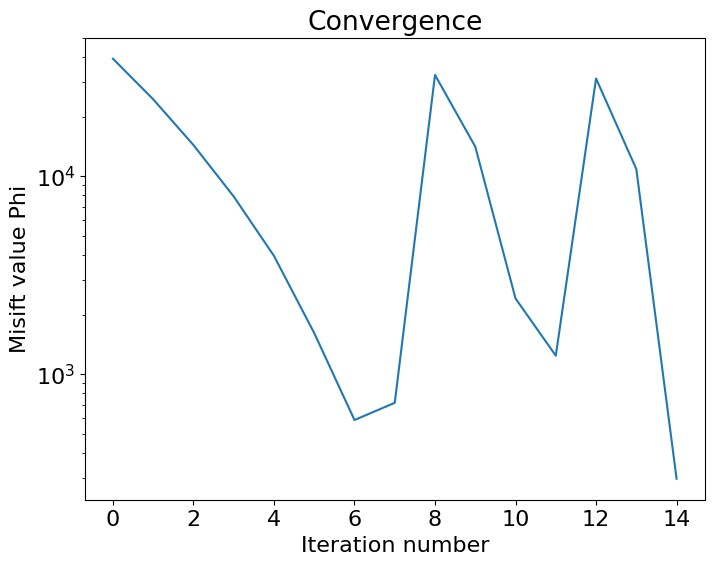

In [320]:
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.semilogy(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

Above, this 'back and forth' movement is the result of a fixed step size. The idea here is that we are stepping over the minimum because our step size does not change dynamically as we approach the minimum.

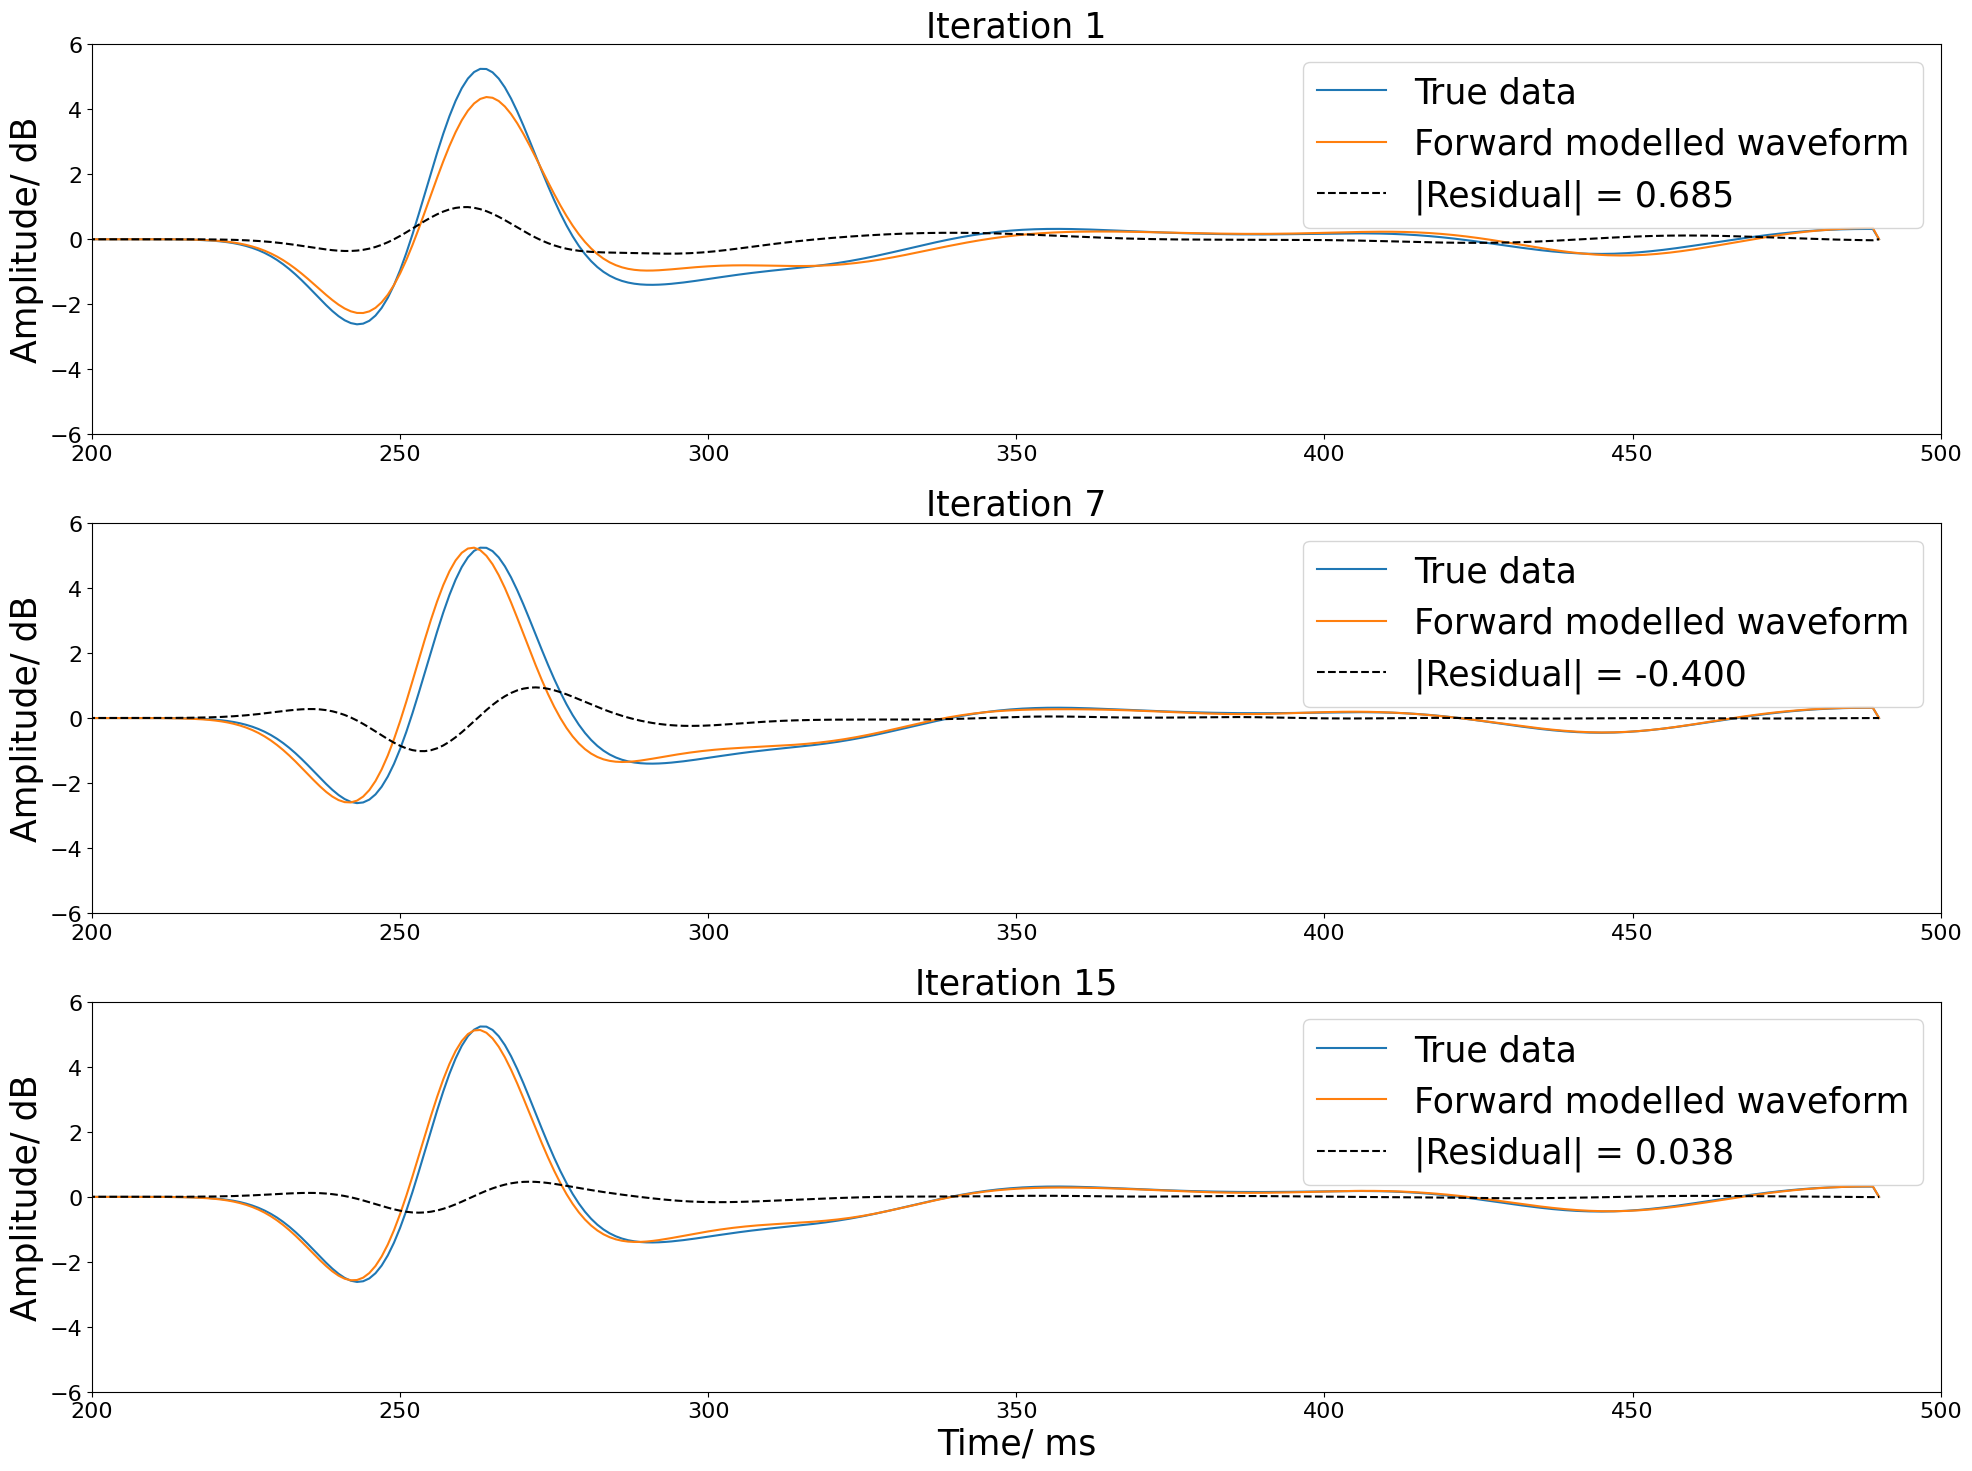

In [363]:
def plot_this(true_d, synthetic_d, ax, it_number, x_title):
    ax.plot(true_d[:, 1], label='True data')
    ax.plot(synthetic_d, label='Forward modelled waveform')
   
    res = true_d[:, 1] - synthetic_d
    
    ax.plot(res, label=f'|Residual| = {sum(res):.3f}', color='k', linestyle='--')
    
    if x_title is True:
        ax.set_xlabel('Time/ ms', fontsize=25)
    ax.set_ylabel('Amplitude/ dB', fontsize=25)
    ax.set_xlim(200, 500)
    ax.set_ylim(-6, 6)
    ax.set_title(f'Iteration {it_number}', fontsize=25)
    ax.legend(fontsize=25)
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15))
plot_this(true_d.data, synth[0], ax1, 1, False)
plot_this(true_d.data, synth[7], ax2, 7, False)
plot_this(true_d.data, synth[14], ax3, 15, True)
fig.tight_layout()

## Appendix

### Taylor Series derivations

We use Tayor Series throughout this module to derive various things, from FD stencils to the gradient descent method. This is a more thorough write up of those derivations.

The Taylor series of a function $f$ of a single variable $x$ about a point $x+\delta x$ can be written as

$$f(x + \delta x) = f(x) + \delta x f'(x) + \frac{1}{2!}\delta x^2 f''(x) + \dots + \frac{1}{n!} \delta x^{n}f^n(x),$$

or equivalently

$$f(x + \delta x) = f(x) + \delta x f'(x) + \frac{1}{2!}\delta x^2 f''(x) + O(\delta x^2),\ (1)$$

where $O(\delta x^2)$ represents all terms higher than 2nd order and thus the *truncation error* associated with making an approximation by discarding higher order terms. Similarly, about a point $x-\delta x$ the expansion is

$$f(x - \delta x) = f(x) - \delta x f'(x) + \frac{1}{2!}\delta x^2 f''(x) + O(\delta x).\ (2)$$

#### Finite Differencing

We can obtain a simple stencil for a first order forward derivative estimation by rearranging (1) to find

$$f'(x) = \frac{f(x+\delta x) - f(x)}{\delta x} + O(\delta x),$$

and the backwards scheme can be found by rearranging (2) to find

$$f'(x) = \frac{f(x) - f(x-\delta x)}{\delta x} + O(\delta x).$$

The central difference scheme can be found by rearranging (1) - (2) like

$$(1)-(2) \Leftrightarrow f(x+\delta x) - f(x+\delta x) = 2\delta xf'(x) + O(\delta x^2),$$

$$\Rightarrow f'(x) = \frac{f(x+\delta x) - f(x-\delta x)}{2\delta x} + O(\delta x^2).$$

A second derivative approximation can be found by computing (1) + (2) like

$$(1)+(2) \Leftrightarrow f(x+\delta x) + f(x-\delta x) = 2f(x)+\delta x^2 f''(x) + O(\delta x^2),$$

$$\Rightarrow f''(x)=\frac{f(x+\delta x) + f(x-\delta x) - 2f(x)}{\delta x^2} + O(\delta x^2).$$

#### Deriving a Time Stepping Scheme

How can we use this to develop a time stepping scheme to solve PDEs? Well, let's consider the acoustic wave equation to approach this question, which can be written as

$$\frac{1}{c^2}u_{tt} = u_{xx}.$$

From observation, we can see that if we want to arrive at a dicretised expression for a solution, we are going to need two 2nd order derivative approximations. In time, we have

$$u_{tt} = u''(x, t)=\frac{u(x, t+\delta t) + u(x, t-\delta t) - 2u(x, t)}{\delta t^2} + O(\delta t^2),$$

and in space,

$$u_{xx} = u''(x, t)=\frac{u(x+\delta x, t) + u(x -\delta x, t) - 2u(x, t)}{\delta x^2} + O(\delta x^2).$$

Now, let

$$u(x, t) :=u^x_t,$$

and thus let

$$u(x+\delta x, t) := u_{x+1}^{t},$$

be a step forward in a discrete grid representing space, and 

$$u(x, t+\delta t) :=u_{x}^{t+1},$$

be a step forward in a discrete grid representing time. The same notation logic follows for steps backwards. Then, ignoring terms higher than 2nd order, we can write the wave equation to be

$$\frac{1}{c^2}\frac{u_x^{t+1} + u_x^{t-1} - 2u_x^t}{\delta t^2}=\frac{u_{x+1}^t + u^t_{x-1} - 2u^t_x}{\delta x^2}.$$

Rearranging for $u_x^{t+1}$ to obtain a forward time stepping scheme leads us finally to 

$$u^{t+1}_x = 2u^t_x - u_x^{t-1} + \frac{c^2 \delta t^2}{\delta x^2}(u^t_{x+1} + u^{t}_{x-1}-2u^{t}_x).$$

#### Derivation of a Gradient Descent Scheme

In an inversion iteration, how do we figure out the update we should apply to our model? Well, we seek the direction to step in which moves a model *residual* towards a minimum. We can begin with a simple single variable scalar case before generalising to vectors. 

Starting from 

$$f'(x) = \frac{f(x+\delta x) - f(x)}{\delta x},$$

we can write

$$f(x+\delta x)=\delta x f'(x)+f(x).$$

Now, in scalar gradient descent schemes we are seeking the step size $\delta x$ which minimises $f(x+\delta x)$. This can be found to be the value of $\delta x$ which satsifies $f'(x+\delta x)$ = 0. Differentiating and setting equal to zero leads us to

$$\frac{\partial}{\partial x}f(x) = f'(x) = 0,$$

$$0 = \delta x f''(x) - f'(x).$$

Rearranging, we find

$$\delta x = -\frac{f'(x)}{f''(x)},$$

which we can write as an iterative update scheme as

$$x_{n+1} =x_n - \frac{f'(x)}{f''(x)}.$$

That is the scalar case. Now, how do we generalise to vectors? Well, for a scalar function $f$ of a vector $\mathbf{m}$, the analogous expression is

$$f(\mathbf{m}) = f(\mathbf{m}+\delta\mathbf{m}) = f(\mathbf{m})+\delta\mathbf{m}^T\frac{\partial f}{\partial \mathbf{m}} + \frac{1}{2}\delta \mathbf{m}^T\frac{\partial^2 f}{\partial \mathbf{m}^2} + O(\delta\mathbf{m}^3).$$

And using the well known result that

$$\frac{\partial}{\partial \mathbf{m}}\left(\mathbf{x}^T A \mathbf{x}\right) = (\mathbf{x}^T A)^T + A\mathbf{x},$$

we can differentiate this expression with respect to $\mathbf{m}$ to find

$$\frac{\partial f}{\partial \mathbf{m}}\biggr|_{\mathbf{m = m_0 + \delta \mathbf{m}}} = 
\frac{\partial f}{\partial \mathbf{m}}\biggr|_{\mathbf{m = m_0}} + 
\frac{\partial^2 f}{\partial \mathbf{m}^2}\biggr|_{\mathbf{m = m_0}} \, \delta \mathbf{m} + 
\mathcal{O}(\|\delta \mathbf{m}\|^2).$$

Rearranging, we arrive at

$$\delta \mathbf{m}\approx -\left(\frac{\partial^2f}{\partial \mathbf{m}}\right)^2\frac{\partial f}{\partial \mathbf{m}}=-\mathbf{H}^{-1}\nabla_{\mathbf{m}}f, $$

where $\mathbf{H}$ is the Hessian matrix of second order derivatives and $\nabla_{\mathbf{m}}f$ is the gradient of the objective function $f$, both evaluated at $\mathbf{m_0}$. Our vector generalisation is hereby complete.

Note, in the method of steepest descent it is rarely viable to compute the Hessian directly. Consequently we typically use a scalar pre-multiplier $\alpha,\ \alpha \in \mathbb{R}$ and our iterative update scheme is 

$$\mathbf{m_{n+1}} = \mathbf{m_n} -\alpha\nabla_{\mathbf{m}}f.$$